In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd

from itertools import product

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

#Data Preprocessing

In [ ]:
data = pd.read_csv('departures_202207060819.csv')
data

,id,departure_airport,arrival_airport,time_frame,estimated_departure,estimated_arrival,aircraft_icao24,callsign,owner
0,1,KATL,NaN,NaN,2018-01-01 01:16:56.000,2018-01-01 02:14:51.000,ab5ade,SWA4082,Southwest Airlines Co
1,1256,KSEA,6WA3,NaN,2019-10-18 20:47:14.000,2019-10-18 21:10:16.000,a7ef08,CPZ5753,Delta Air Lines Inc
2,1334,KATL,NaN,NaN,2019-11-04 20:13:00.000,2019-11-04 21:06:07.000,a90383,DAL1293,Delta Air Lines Inc
3,1407,KFLL,NaN,NaN,2019-12-13 16:58:05.000,2019-12-13 17:10:49.000,a9f7d2,SWA1215,Southwest Airlines Co
4,1410,KPHX,KPHL,NaN,2019-12-21 06:28:00.000,2019-12-21 10:26:25.000,a19eff,AAL1658,American Airlines
...,...,...,...,...,...,...,...,...,...
4099,4019,KDEN,KTUS,NaN,2022-06-25 14:34:10.000,2022-06-25 16:07:38.000,abf308,SWA4540,Southwest Airlines Co
4100,4022,KDEN,NaN,NaN,2022-06-25 15:59:12.000,2022-06-25 16:28:09.000,abb5bf,SWA500,Southwest Airlines Co
4101,4023,KDEN,KLGA,NaN,2022-06-25 15:39:31.000,2022-06-25 18:59:29.000,a44d85,DAL1655,Delta Air Lines Inc
4102,4089,KMSP,KMKE,NaN,2022-07-01 19:02:06.000,2022-07-01 19:44:44.000,a70e7a,SKW4451,Delta Air Lines Inc


In [ ]:
data.dtypes

id                       int64
departure_airport       object
arrival_airport         object
time_frame             float64
estimated_departure     object
estimated_arrival       object
aircraft_icao24         object
callsign                object
owner                   object
dtype: object

In [ ]:
data= data.astype({"owner": str})

In [ ]:
import numpy
(unique, counts) = numpy.unique(data["owner"], return_counts=True)
frequencies = numpy.asarray((unique, counts)).T
frequencies

array([['American Airlines', 189],
       ['American Airlines  Inc', 1],
       ['American Airlines Inc', 1082],
       ['Delta Air Lines', 133],
       ['Delta Air Lines Inc', 969],
       ['Delta Air Lnes Inc', 2],
       ['Southwest Airlines', 83],
       ['Southwest Airlines Co', 661],
       ['Southwest Airlines Inc', 2],
       ['United Airlines', 39],
       ['United Airlines Inc', 943]], dtype=object)

In [ ]:
dataBasedOnAirlines = {}

for airline in unique:
  if airline == 'American Airlines' or airline == 'American Airlines  Inc' or airline == 'American Airlines Inc': 
    segmentedData = data.query('owner == @airline')
    segmentedData.drop(['owner'], inplace=True, axis=1)
    dataBasedOnAirlines[airline] = segmentedData
  if airline == 'Southwest Airlines' or airline =='Southwest Airlines Co' or airline =='Southwest Airlines Inc':
    segmentedData = data.query('owner == @airline')
    segmentedData.drop(['owner'], inplace=True, axis=1)
    dataBasedOnAirlines[airline] = segmentedData
  if airline == 'Delta Air Lines' or airline == 'Delta Air Lines Inc' or airline == 'Delta Air Lnes Inc':
    segmentedData = data.query('owner == @airline')
    segmentedData.drop(['owner'], inplace=True, axis=1)
    dataBasedOnAirlines[airline] = segmentedData
  if airline == 'United Airlines' or airline == 'United Airlines Inc':
    segmentedData = data.query('owner == @airline')
    segmentedData.drop(['owner'], inplace=True, axis=1)
    dataBasedOnAirlines[airline] = segmentedData

dataBasedOnAirlines

{'American Airlines':         id departure_airport arrival_airport  time_frame  \
 4     1410              KPHX            KPHL         NaN   
 33    2525              KPHL            KMIA         NaN   
 40    2667              KEWR            KDFW         NaN   
 41    2668              KEWR            KMIA         NaN   
 70    3082              KMCO            KPHL         NaN   
 ...    ...               ...             ...         ...   
 3857  3620              KMIA            MDSD         NaN   
 3900  3580              KMCO            KORD         NaN   
 3920  3971              KMCO            KCLT         NaN   
 3941  3500              KORD            KPHX         NaN   
 4043  3858              KDFW            MMUN         NaN   
 
           estimated_departure        estimated_arrival aircraft_icao24  \
 4     2019-12-21 06:28:00.000  2019-12-21 10:26:25.000          a19eff   
 33    2021-04-27 21:57:08.000  2021-04-27 23:58:58.000          adb476   
 40    2021-06-12 21

In [ ]:
dataBasedOnAirlines['American Airlines']

,id,departure_airport,arrival_airport,time_frame,estimated_departure,estimated_arrival,aircraft_icao24,callsign
4,1410,KPHX,KPHL,NaN,2019-12-21 06:28:00.000,2019-12-21 10:26:25.000,a19eff,AAL1658
33,2525,KPHL,KMIA,NaN,2021-04-27 21:57:08.000,2021-04-27 23:58:58.000,adb476,AAL2595
40,2667,KEWR,KDFW,NaN,2021-06-12 21:41:56.000,2021-06-13 00:32:59.000,ad7634,AAL558
41,2668,KEWR,KMIA,NaN,2021-06-12 21:59:07.000,2021-06-13 00:20:44.000,adeca5,AAL2933
70,3082,KMCO,KPHL,NaN,2021-10-04 19:02:00.000,2021-10-04 21:01:59.000,adc531,AAL1719
...,...,...,...,...,...,...,...,...
3857,3620,KMIA,MDSD,NaN,2022-03-09 23:57:08.000,2022-03-10 01:50:29.000,add793,AAL1511
3900,3580,KMCO,KORD,NaN,2022-03-12 13:28:56.000,2022-03-12 15:56:42.000,adddd5,AAL2721
3920,3971,KMCO,KCLT,NaN,2022-06-28 09:04:43.000,2022-06-28 10:11:29.000,ad857e,AAL2786
3941,3500,KORD,KPHX,NaN,2022-02-22 12:09:32.000,2022-02-22 15:55:20.000,ad7b17,AAL2800


In [ ]:
frames = [dataBasedOnAirlines['American Airlines'], dataBasedOnAirlines['American Airlines  Inc'], dataBasedOnAirlines['American Airlines Inc']]

dataAmericanAirlines = pd.concat(frames)
dataAmericanAirlines

,id,departure_airport,arrival_airport,time_frame,estimated_departure,estimated_arrival,aircraft_icao24,callsign
4,1410,KPHX,KPHL,NaN,2019-12-21 06:28:00.000,2019-12-21 10:26:25.000,a19eff,AAL1658
33,2525,KPHL,KMIA,NaN,2021-04-27 21:57:08.000,2021-04-27 23:58:58.000,adb476,AAL2595
40,2667,KEWR,KDFW,NaN,2021-06-12 21:41:56.000,2021-06-13 00:32:59.000,ad7634,AAL558
41,2668,KEWR,KMIA,NaN,2021-06-12 21:59:07.000,2021-06-13 00:20:44.000,adeca5,AAL2933
70,3082,KMCO,KPHL,NaN,2021-10-04 19:02:00.000,2021-10-04 21:01:59.000,adc531,AAL1719
...,...,...,...,...,...,...,...,...
4078,3663,KDFW,NaN,NaN,2022-04-02 16:05:18.000,2022-04-02 17:06:56.000,a26f01,ENY3701
4079,3699,KDFW,NaN,NaN,2022-04-25 01:57:30.000,2022-04-25 03:56:26.000,aae582,AAL767
4088,3857,KDFW,NaN,NaN,2022-05-28 13:51:02.000,2022-05-28 15:24:45.000,a26f01,ENY4043
4091,3861,KPHL,CYYZ,NaN,2022-06-11 01:17:39.000,2022-06-11 02:22:28.000,a7b133,JIA5116


In [ ]:
frames = [dataBasedOnAirlines['Southwest Airlines'], dataBasedOnAirlines['Southwest Airlines Co'], dataBasedOnAirlines['Southwest Airlines Inc']]

dataSoutwestAirlines = pd.concat(frames)
dataSoutwestAirlines

,id,departure_airport,arrival_airport,time_frame,estimated_departure,estimated_arrival,aircraft_icao24,callsign
136,2408,KLAS,KSLC,NaN,2021-04-05 03:51:51.000,2021-04-05 04:44:55.000,a29748,SWA1711
189,1414,KSEA,KLAS,NaN,2019-12-17 17:37:38.000,2019-12-17 19:38:39.000,a196c8,SWA2033
215,2025,KDEN,KSNA,NaN,2020-10-07 21:03:34.000,2020-10-07 22:58:47.000,abd8a5,SWA1059
249,982,KDEN,KSDF,NaN,2019-07-27 19:04:00.000,2019-07-27 21:07:57.000,a20a81,SWA4126
266,1701,KBOS,KSTL,NaN,2020-05-04 19:11:23.000,2020-05-04 21:46:39.000,aba9e7,SWA1494
...,...,...,...,...,...,...,...,...
4086,3821,KMSP,KDEN,NaN,2022-05-17 16:57:00.000,2022-05-17 18:33:11.000,acdde3,SWA549
4099,4019,KDEN,KTUS,NaN,2022-06-25 14:34:10.000,2022-06-25 16:07:38.000,abf308,SWA4540
4100,4022,KDEN,NaN,NaN,2022-06-25 15:59:12.000,2022-06-25 16:28:09.000,abb5bf,SWA500
570,1789,KDEN,KBOS,NaN,2020-06-27 23:17:14.000,2020-06-28 02:35:59.000,abb5e2,SWA1301


In [ ]:
frames = [dataBasedOnAirlines['Delta Air Lines'], dataBasedOnAirlines['Delta Air Lines Inc'], dataBasedOnAirlines['Delta Air Lnes Inc']]

dataDeltaAirlines = pd.concat(frames)
dataDeltaAirlines

,id,departure_airport,arrival_airport,time_frame,estimated_departure,estimated_arrival,aircraft_icao24,callsign
60,2946,KFLL,KATL,NaN,2021-08-29 12:18:30.000,2021-08-29 13:45:24.000,a8e37c,DAL2453
75,4,KATL,NaN,NaN,2018-01-01 00:41:09.000,2018-01-01 00:57:25.000,a3271a,DAL1102
123,1693,KATL,KSDF,NaN,2020-04-28 15:02:07.000,2020-04-28 15:59:11.000,acd115,DAL348
131,2190,KPHL,KATL,NaN,2020-12-15 13:52:04.000,2020-12-15 15:36:35.000,ad273b,DAL1278
141,2670,KATL,NaN,NaN,2021-06-13 02:11:10.000,2021-06-13 03:42:18.000,adc8ee,DAL1127
...,...,...,...,...,...,...,...,...
4101,4023,KDEN,KLGA,NaN,2022-06-25 15:39:31.000,2022-06-25 18:59:29.000,a44d85,DAL1655
4102,4089,KMSP,KMKE,NaN,2022-07-01 19:02:06.000,2022-07-01 19:44:44.000,a70e7a,SKW4451
4103,3162,KATL,KRDU,NaN,2021-10-28 13:31:00.000,2021-10-28 14:21:42.000,a426a5,DAL2633
512,3010,KSEA,KJFK,NaN,2021-09-23 05:50:33.000,2021-09-23 10:38:49.000,a95dba,DAL484


In [ ]:
frames = [dataBasedOnAirlines['United Airlines'], dataBasedOnAirlines['United Airlines Inc']]

dataUnitedAirlines = pd.concat(frames)
dataUnitedAirlines

,id,departure_airport,arrival_airport,time_frame,estimated_departure,estimated_arrival,aircraft_icao24,callsign
230,643,KLAS,KEWR,NaN,2019-04-16 13:27:42.000,2019-04-16 17:42:46.000,a16e7d,UAL548
310,339,KLAX,TS07,NaN,2018-09-03 08:22:00.000,2018-09-03 10:56:24.000,a8d46a,UAL1614
452,3505,KMSP,KORD,NaN,2022-02-19 14:17:07.000,2022-02-19 15:09:46.000,ac4ace,UAL1753
454,174,KEWR,KHWO,NaN,2018-01-23 23:51:53.000,2018-01-24 02:37:28.000,a8856d,UAL1086
510,2985,KLAX,NaN,NaN,2021-09-16 01:28:37.000,2021-09-16 05:11:16.000,a46d95,UAL1282
...,...,...,...,...,...,...,...,...
4080,3742,KSFO,KDEN,NaN,2022-04-24 15:59:34.000,2022-04-24 17:59:15.000,a4b5d2,UAL1826
4081,3747,KDEN,KCOS,NaN,2022-04-22 21:51:07.000,2022-04-22 22:20:53.000,a4efe4,UAL564
4087,3856,KEWR,95FD,NaN,2022-06-09 01:09:42.000,2022-06-09 03:30:13.000,a0acb6,UAL1642
4090,3860,KORD,KLGA,NaN,2022-05-24 22:21:22.000,2022-05-24 23:55:19.000,a097e9,UAL1935


In [ ]:
print(dataAmericanAirlines)
print(dataSoutwestAirlines)
print(dataDeltaAirlines)
print(dataUnitedAirlines)

        id departure_airport arrival_airport  time_frame  \
4     1410              KPHX            KPHL         NaN   
33    2525              KPHL            KMIA         NaN   
40    2667              KEWR            KDFW         NaN   
41    2668              KEWR            KMIA         NaN   
70    3082              KMCO            KPHL         NaN   
...    ...               ...             ...         ...   
4078  3663              KDFW             NaN         NaN   
4079  3699              KDFW             NaN         NaN   
4088  3857              KDFW             NaN         NaN   
4091  3861              KPHL            CYYZ         NaN   
4093  3891              KMCO            KUZA         NaN   

          estimated_departure        estimated_arrival aircraft_icao24  \
4     2019-12-21 06:28:00.000  2019-12-21 10:26:25.000          a19eff   
33    2021-04-27 21:57:08.000  2021-04-27 23:58:58.000          adb476   
40    2021-06-12 21:41:56.000  2021-06-13 00:32:59.000   

In [ ]:
dataAmericanAirlines.dtypes

id                       int64
departure_airport       object
arrival_airport         object
time_frame             float64
estimated_departure     object
estimated_arrival       object
aircraft_icao24         object
callsign                object
dtype: object

In [ ]:
dataAmericanAirlines['estimated_departure'] = pd.to_datetime(dataAmericanAirlines['estimated_departure'])
dataSoutwestAirlines['estimated_departure'] = pd.to_datetime(dataSoutwestAirlines['estimated_departure'])
dataDeltaAirlines['estimated_departure'] = pd.to_datetime(dataDeltaAirlines['estimated_departure'])
dataUnitedAirlines['estimated_departure'] = pd.to_datetime(dataUnitedAirlines['estimated_departure'])

#American Airlines

In [ ]:
dataAmericanAirlines['DAY'] = dataAmericanAirlines['estimated_departure'].dt.day
dataAmericanAirlines['MONTH'] = dataAmericanAirlines['estimated_departure'].dt.month
dataAmericanAirlines['YEAR'] = dataAmericanAirlines['estimated_departure'].dt.year
dataAmericanAirlines

,id,departure_airport,arrival_airport,time_frame,estimated_departure,estimated_arrival,aircraft_icao24,callsign,DAY,MONTH,YEAR
4,1410,KPHX,KPHL,NaN,2019-12-21 06:28:00,2019-12-21 10:26:25.000,a19eff,AAL1658,21,12,2019
33,2525,KPHL,KMIA,NaN,2021-04-27 21:57:08,2021-04-27 23:58:58.000,adb476,AAL2595,27,4,2021
40,2667,KEWR,KDFW,NaN,2021-06-12 21:41:56,2021-06-13 00:32:59.000,ad7634,AAL558,12,6,2021
41,2668,KEWR,KMIA,NaN,2021-06-12 21:59:07,2021-06-13 00:20:44.000,adeca5,AAL2933,12,6,2021
70,3082,KMCO,KPHL,NaN,2021-10-04 19:02:00,2021-10-04 21:01:59.000,adc531,AAL1719,4,10,2021
...,...,...,...,...,...,...,...,...,...,...,...
4078,3663,KDFW,NaN,NaN,2022-04-02 16:05:18,2022-04-02 17:06:56.000,a26f01,ENY3701,2,4,2022
4079,3699,KDFW,NaN,NaN,2022-04-25 01:57:30,2022-04-25 03:56:26.000,aae582,AAL767,25,4,2022
4088,3857,KDFW,NaN,NaN,2022-05-28 13:51:02,2022-05-28 15:24:45.000,a26f01,ENY4043,28,5,2022
4091,3861,KPHL,CYYZ,NaN,2022-06-11 01:17:39,2022-06-11 02:22:28.000,a7b133,JIA5116,11,6,2022


In [ ]:
dataAmericanAirlines.drop(['id', 'departure_airport', 'arrival_airport', 'time_frame', 'estimated_departure', 'estimated_arrival', 'aircraft_icao24', 'callsign'], inplace=True, axis=1)
dataAmericanAirlines

,DAY,MONTH,YEAR
4,21,12,2019
33,27,4,2021
40,12,6,2021
41,12,6,2021
70,4,10,2021
...,...,...,...
4078,2,4,2022
4079,25,4,2022
4088,28,5,2022
4091,11,6,2022


In [ ]:
dataAmericanAirlines['Datetime'] = pd.to_datetime( dataAmericanAirlines[['YEAR', 'MONTH', 'DAY']])
dataAmericanAirlines

,DAY,MONTH,YEAR,Datetime
4,21,12,2019,2019-12-21
33,27,4,2021,2021-04-27
40,12,6,2021,2021-06-12
41,12,6,2021,2021-06-12
70,4,10,2021,2021-10-04
...,...,...,...,...
4078,2,4,2022,2022-04-02
4079,25,4,2022,2022-04-25
4088,28,5,2022,2022-05-28
4091,11,6,2022,2022-06-11


In [ ]:
(unique1, counts1) = numpy.unique(dataAmericanAirlines["Datetime"], return_counts=True)
frequencies1 = numpy.asarray((unique1, counts1)).T
frequencies1

array([[1514764800000000000, 15],
       [1514851200000000000, 1],
       [1514937600000000000, 1],
       [1515110400000000000, 1],
       [1515196800000000000, 1],
       [1515283200000000000, 4],
       [1515715200000000000, 16],
       [1515801600000000000, 2],
       [1515888000000000000, 1],
       [1515974400000000000, 2],
       [1516320000000000000, 3],
       [1516492800000000000, 6],
       [1516665600000000000, 2],
       [1516752000000000000, 1],
       [1516838400000000000, 2],
       [1517097600000000000, 1],
       [1517616000000000000, 2],
       [1518393600000000000, 1],
       [1518825600000000000, 2],
       [1518998400000000000, 1],
       [1522627200000000000, 1],
       [1522713600000000000, 1],
       [1524873600000000000, 2],
       [1525478400000000000, 1],
       [1526428800000000000, 1],
       [1526947200000000000, 1],
       [1528156800000000000, 1],
       [1528848000000000000, 1],
       [1530662400000000000, 1],
       [1530835200000000000, 1],
       [

In [ ]:
AmericanAirlineActualData = pd.DataFrame(frequencies1, columns=["Date", "Count"])
AmericanAirlineActualData

,Date,Count
0,1514764800000000000,15
1,1514851200000000000,1
2,1514937600000000000,1
3,1515110400000000000,1
4,1515196800000000000,1
...,...,...
475,1656115200000000000,1
476,1656288000000000000,2
477,1656374400000000000,1
478,1656547200000000000,1


In [ ]:
AmericanAirlineActualData["Date"] = pd.to_datetime(AmericanAirlineActualData["Date"])
AmericanAirlineActualData

,Date,Count
0,2018-01-01,15
1,2018-01-02,1
2,2018-01-03,1
3,2018-01-05,1
4,2018-01-06,1
...,...,...
475,2022-06-25,1
476,2022-06-27,2
477,2022-06-28,1
478,2022-06-30,1


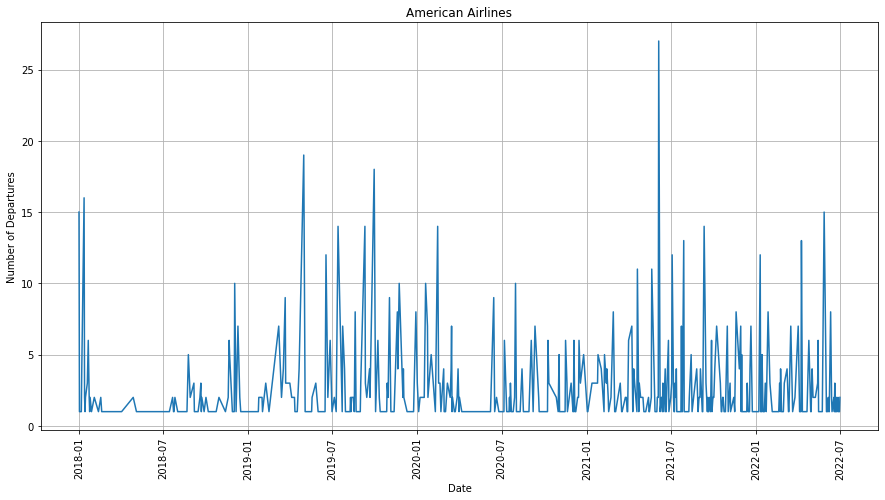

In [ ]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(AmericanAirlineActualData['Date'], AmericanAirlineActualData['Count'])
plt.title('American Airlines')
plt.ylabel('Number of Departures')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

#SouthWest Airlines

In [ ]:
dataSoutwestAirlines['DAY'] = dataSoutwestAirlines['estimated_departure'].dt.day
dataSoutwestAirlines['MONTH'] = dataSoutwestAirlines['estimated_departure'].dt.month
dataSoutwestAirlines['YEAR'] = dataSoutwestAirlines['estimated_departure'].dt.year
dataSoutwestAirlines

,id,departure_airport,arrival_airport,time_frame,estimated_departure,estimated_arrival,aircraft_icao24,callsign,DAY,MONTH,YEAR
136,2408,KLAS,KSLC,NaN,2021-04-05 03:51:51,2021-04-05 04:44:55.000,a29748,SWA1711,5,4,2021
189,1414,KSEA,KLAS,NaN,2019-12-17 17:37:38,2019-12-17 19:38:39.000,a196c8,SWA2033,17,12,2019
215,2025,KDEN,KSNA,NaN,2020-10-07 21:03:34,2020-10-07 22:58:47.000,abd8a5,SWA1059,7,10,2020
249,982,KDEN,KSDF,NaN,2019-07-27 19:04:00,2019-07-27 21:07:57.000,a20a81,SWA4126,27,7,2019
266,1701,KBOS,KSTL,NaN,2020-05-04 19:11:23,2020-05-04 21:46:39.000,aba9e7,SWA1494,4,5,2020
...,...,...,...,...,...,...,...,...,...,...,...
4086,3821,KMSP,KDEN,NaN,2022-05-17 16:57:00,2022-05-17 18:33:11.000,acdde3,SWA549,17,5,2022
4099,4019,KDEN,KTUS,NaN,2022-06-25 14:34:10,2022-06-25 16:07:38.000,abf308,SWA4540,25,6,2022
4100,4022,KDEN,NaN,NaN,2022-06-25 15:59:12,2022-06-25 16:28:09.000,abb5bf,SWA500,25,6,2022
570,1789,KDEN,KBOS,NaN,2020-06-27 23:17:14,2020-06-28 02:35:59.000,abb5e2,SWA1301,27,6,2020


In [ ]:
dataSoutwestAirlines.drop(['id', 'departure_airport', 'arrival_airport', 'time_frame', 'estimated_departure', 'estimated_arrival', 'aircraft_icao24', 'callsign'], inplace=True, axis=1)
dataSoutwestAirlines

,DAY,MONTH,YEAR
136,5,4,2021
189,17,12,2019
215,7,10,2020
249,27,7,2019
266,4,5,2020
...,...,...,...
4086,17,5,2022
4099,25,6,2022
4100,25,6,2022
570,27,6,2020


In [ ]:
dataSoutwestAirlines['Datetime'] = pd.to_datetime( dataSoutwestAirlines[['YEAR', 'MONTH', 'DAY']])
dataSoutwestAirlines

,DAY,MONTH,YEAR,Datetime
136,5,4,2021,2021-04-05
189,17,12,2019,2019-12-17
215,7,10,2020,2020-10-07
249,27,7,2019,2019-07-27
266,4,5,2020,2020-05-04
...,...,...,...,...
4086,17,5,2022,2022-05-17
4099,25,6,2022,2022-06-25
4100,25,6,2022,2022-06-25
570,27,6,2020,2020-06-27


In [ ]:
(unique2, counts2) = numpy.unique(dataSoutwestAirlines["Datetime"], return_counts=True)
frequencies2 = numpy.asarray((unique2, counts2)).T
frequencies2

array([[1514764800000000000, 6],
       [1514937600000000000, 2],
       [1515196800000000000, 2],
       [1515283200000000000, 1],
       [1516406400000000000, 4],
       [1516492800000000000, 1],
       [1516665600000000000, 1],
       [1516752000000000000, 6],
       [1517097600000000000, 5],
       [1517529600000000000, 1],
       [1517616000000000000, 1],
       [1520553600000000000, 1],
       [1520726400000000000, 1],
       [1521244800000000000, 2],
       [1521504000000000000, 1],
       [1521590400000000000, 1],
       [1521763200000000000, 2],
       [1523059200000000000, 1],
       [1523491200000000000, 1],
       [1525737600000000000, 1],
       [1526256000000000000, 2],
       [1526428800000000000, 2],
       [1526601600000000000, 1],
       [1529366400000000000, 1],
       [1529625600000000000, 1],
       [1531353600000000000, 1],
       [1532390400000000000, 1],
       [1532649600000000000, 2],
       [1533772800000000000, 1],
       [1534377600000000000, 2],
       [15

In [ ]:
SoutwestAirlineActualData = pd.DataFrame(frequencies2, columns=["Date", "Count"])
SoutwestAirlineActualData

,Date,Count
0,1514764800000000000,6
1,1514937600000000000,2
2,1515196800000000000,2
3,1515283200000000000,1
4,1516406400000000000,4
...,...,...
338,1655942400000000000,1
339,1656028800000000000,1
340,1656115200000000000,14
341,1656288000000000000,3


In [ ]:
SoutwestAirlineActualData["Date"] = pd.to_datetime(SoutwestAirlineActualData["Date"])
SoutwestAirlineActualData

,Date,Count
0,2018-01-01,6
1,2018-01-03,2
2,2018-01-06,2
3,2018-01-07,1
4,2018-01-20,4
...,...,...
338,2022-06-23,1
339,2022-06-24,1
340,2022-06-25,14
341,2022-06-27,3


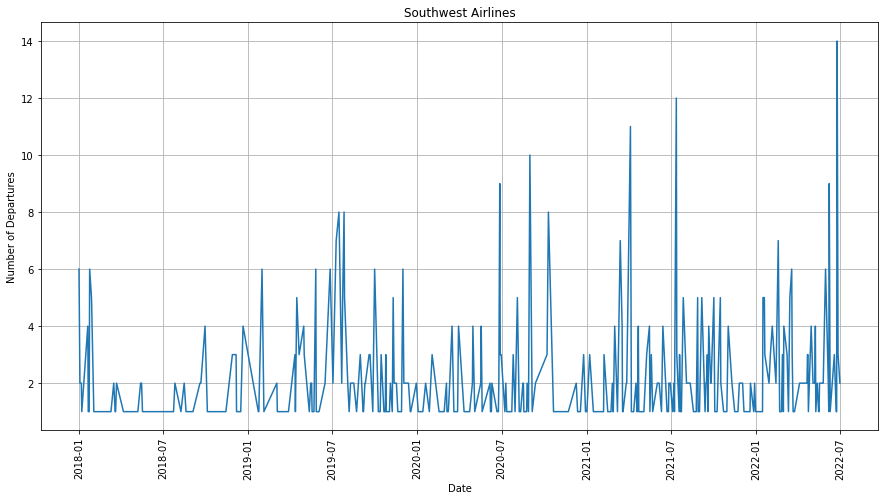

In [ ]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(SoutwestAirlineActualData['Date'], SoutwestAirlineActualData['Count'])
plt.title('Southwest Airlines')
plt.ylabel('Number of Departures')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

#Delta Airlines

In [ ]:
dataDeltaAirlines['DAY'] = dataDeltaAirlines['estimated_departure'].dt.day
dataDeltaAirlines['MONTH'] = dataDeltaAirlines['estimated_departure'].dt.month
dataDeltaAirlines['YEAR'] = dataDeltaAirlines['estimated_departure'].dt.year
dataDeltaAirlines

,id,departure_airport,arrival_airport,time_frame,estimated_departure,estimated_arrival,aircraft_icao24,callsign,DAY,MONTH,YEAR
60,2946,KFLL,KATL,NaN,2021-08-29 12:18:30,2021-08-29 13:45:24.000,a8e37c,DAL2453,29,8,2021
75,4,KATL,NaN,NaN,2018-01-01 00:41:09,2018-01-01 00:57:25.000,a3271a,DAL1102,1,1,2018
123,1693,KATL,KSDF,NaN,2020-04-28 15:02:07,2020-04-28 15:59:11.000,acd115,DAL348,28,4,2020
131,2190,KPHL,KATL,NaN,2020-12-15 13:52:04,2020-12-15 15:36:35.000,ad273b,DAL1278,15,12,2020
141,2670,KATL,NaN,NaN,2021-06-13 02:11:10,2021-06-13 03:42:18.000,adc8ee,DAL1127,13,6,2021
...,...,...,...,...,...,...,...,...,...,...,...
4101,4023,KDEN,KLGA,NaN,2022-06-25 15:39:31,2022-06-25 18:59:29.000,a44d85,DAL1655,25,6,2022
4102,4089,KMSP,KMKE,NaN,2022-07-01 19:02:06,2022-07-01 19:44:44.000,a70e7a,SKW4451,1,7,2022
4103,3162,KATL,KRDU,NaN,2021-10-28 13:31:00,2021-10-28 14:21:42.000,a426a5,DAL2633,28,10,2021
512,3010,KSEA,KJFK,NaN,2021-09-23 05:50:33,2021-09-23 10:38:49.000,a95dba,DAL484,23,9,2021


In [ ]:
dataDeltaAirlines.drop(['id', 'departure_airport', 'arrival_airport', 'time_frame', 'estimated_departure', 'estimated_arrival', 'aircraft_icao24', 'callsign'], inplace=True, axis=1)
dataDeltaAirlines

,DAY,MONTH,YEAR
60,29,8,2021
75,1,1,2018
123,28,4,2020
131,15,12,2020
141,13,6,2021
...,...,...,...
4101,25,6,2022
4102,1,7,2022
4103,28,10,2021
512,23,9,2021


In [ ]:
dataDeltaAirlines['Datetime'] = pd.to_datetime(dataDeltaAirlines[['YEAR', 'MONTH', 'DAY']])
dataDeltaAirlines

,DAY,MONTH,YEAR,Datetime
60,29,8,2021,2021-08-29
75,1,1,2018,2018-01-01
123,28,4,2020,2020-04-28
131,15,12,2020,2020-12-15
141,13,6,2021,2021-06-13
...,...,...,...,...
4101,25,6,2022,2022-06-25
4102,1,7,2022,2022-07-01
4103,28,10,2021,2021-10-28
512,23,9,2021,2021-09-23


In [ ]:
(unique3, counts3) = numpy.unique(dataDeltaAirlines["Datetime"], return_counts=True)
frequencies3 = numpy.asarray((unique3, counts3)).T
frequencies3

array([[1514764800000000000, 3],
       [1514851200000000000, 1],
       [1514937600000000000, 3],
       [1515110400000000000, 1],
       [1515196800000000000, 1],
       [1515456000000000000, 2],
       [1515715200000000000, 1],
       [1515801600000000000, 12],
       [1516147200000000000, 1],
       [1516320000000000000, 5],
       [1516406400000000000, 2],
       [1516492800000000000, 1],
       [1516665600000000000, 3],
       [1516924800000000000, 1],
       [1517011200000000000, 1],
       [1517097600000000000, 1],
       [1517529600000000000, 2],
       [1517616000000000000, 1],
       [1518825600000000000, 3],
       [1519171200000000000, 4],
       [1522713600000000000, 1],
       [1523232000000000000, 1],
       [1523836800000000000, 1],
       [1524096000000000000, 1],
       [1525132800000000000, 5],
       [1530057600000000000, 2],
       [1530835200000000000, 2],
       [1531612800000000000, 2],
       [1532390400000000000, 2],
       [1532649600000000000, 1],
       [1

In [ ]:
DeltaAirlineActualData = pd.DataFrame(frequencies3, columns=["Date", "Count"])
DeltaAirlineActualData

,Date,Count
0,1514764800000000000,3
1,1514851200000000000,1
2,1514937600000000000,3
3,1515110400000000000,1
4,1515196800000000000,1
...,...,...
442,1656115200000000000,3
443,1656201600000000000,1
444,1656288000000000000,2
445,1656547200000000000,14


In [ ]:
DeltaAirlineActualData["Date"] = pd.to_datetime(DeltaAirlineActualData["Date"])
DeltaAirlineActualData

,Date,Count
0,2018-01-01,3
1,2018-01-02,1
2,2018-01-03,3
3,2018-01-05,1
4,2018-01-06,1
...,...,...
442,2022-06-25,3
443,2022-06-26,1
444,2022-06-27,2
445,2022-06-30,14


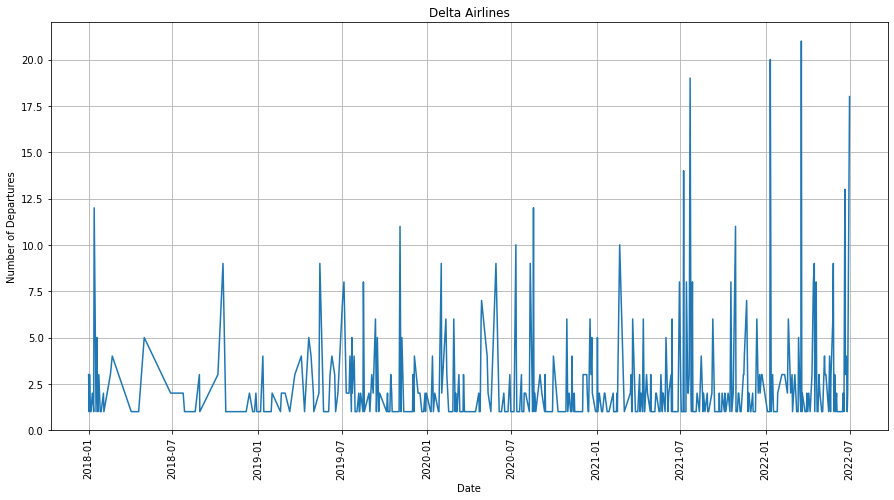

In [ ]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(DeltaAirlineActualData['Date'], DeltaAirlineActualData['Count'])
plt.title('Delta Airlines')
plt.ylabel('Number of Departures')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

#United Airlines

In [ ]:
dataUnitedAirlines['DAY'] = dataUnitedAirlines['estimated_departure'].dt.day
dataUnitedAirlines['MONTH'] = dataUnitedAirlines['estimated_departure'].dt.month
dataUnitedAirlines['YEAR'] = dataUnitedAirlines['estimated_departure'].dt.year
dataUnitedAirlines

,id,departure_airport,arrival_airport,time_frame,estimated_departure,estimated_arrival,aircraft_icao24,callsign,DAY,MONTH,YEAR
230,643,KLAS,KEWR,NaN,2019-04-16 13:27:42,2019-04-16 17:42:46.000,a16e7d,UAL548,16,4,2019
310,339,KLAX,TS07,NaN,2018-09-03 08:22:00,2018-09-03 10:56:24.000,a8d46a,UAL1614,3,9,2018
452,3505,KMSP,KORD,NaN,2022-02-19 14:17:07,2022-02-19 15:09:46.000,ac4ace,UAL1753,19,2,2022
454,174,KEWR,KHWO,NaN,2018-01-23 23:51:53,2018-01-24 02:37:28.000,a8856d,UAL1086,23,1,2018
510,2985,KLAX,NaN,NaN,2021-09-16 01:28:37,2021-09-16 05:11:16.000,a46d95,UAL1282,16,9,2021
...,...,...,...,...,...,...,...,...,...,...,...
4080,3742,KSFO,KDEN,NaN,2022-04-24 15:59:34,2022-04-24 17:59:15.000,a4b5d2,UAL1826,24,4,2022
4081,3747,KDEN,KCOS,NaN,2022-04-22 21:51:07,2022-04-22 22:20:53.000,a4efe4,UAL564,22,4,2022
4087,3856,KEWR,95FD,NaN,2022-06-09 01:09:42,2022-06-09 03:30:13.000,a0acb6,UAL1642,9,6,2022
4090,3860,KORD,KLGA,NaN,2022-05-24 22:21:22,2022-05-24 23:55:19.000,a097e9,UAL1935,24,5,2022


In [ ]:
dataUnitedAirlines.drop(['id', 'departure_airport', 'arrival_airport', 'time_frame', 'estimated_departure', 'estimated_arrival', 'aircraft_icao24', 'callsign'], inplace=True, axis=1)
dataUnitedAirlines

,DAY,MONTH,YEAR
230,16,4,2019
310,3,9,2018
452,19,2,2022
454,23,1,2018
510,16,9,2021
...,...,...,...
4080,24,4,2022
4081,22,4,2022
4087,9,6,2022
4090,24,5,2022


In [ ]:
dataUnitedAirlines['Datetime'] = pd.to_datetime(dataUnitedAirlines[['YEAR', 'MONTH', 'DAY']])
dataUnitedAirlines

,DAY,MONTH,YEAR,Datetime
230,16,4,2019,2019-04-16
310,3,9,2018,2018-09-03
452,19,2,2022,2022-02-19
454,23,1,2018,2018-01-23
510,16,9,2021,2021-09-16
...,...,...,...,...
4080,24,4,2022,2022-04-24
4081,22,4,2022,2022-04-22
4087,9,6,2022,2022-06-09
4090,24,5,2022,2022-05-24


In [ ]:
(unique4, counts4) = numpy.unique(dataUnitedAirlines["Datetime"], return_counts=True)
frequencies4 = numpy.asarray((unique4, counts4)).T
frequencies4

array([[1514764800000000000, 7],
       [1514851200000000000, 1],
       [1515110400000000000, 20],
       [1515196800000000000, 1],
       [1515283200000000000, 2],
       [1515369600000000000, 3],
       [1515456000000000000, 1],
       [1515974400000000000, 2],
       [1516233600000000000, 1],
       [1516406400000000000, 1],
       [1516492800000000000, 4],
       [1516665600000000000, 9],
       [1516752000000000000, 5],
       [1517097600000000000, 2],
       [1517184000000000000, 1],
       [1517529600000000000, 1],
       [1517616000000000000, 7],
       [1517702400000000000, 1],
       [1517875200000000000, 2],
       [1518220800000000000, 2],
       [1518566400000000000, 1],
       [1519516800000000000, 1],
       [1520035200000000000, 4],
       [1520553600000000000, 3],
       [1520726400000000000, 1],
       [1521504000000000000, 1],
       [1521936000000000000, 2],
       [1523923200000000000, 1],
       [1524614400000000000, 1],
       [1525564800000000000, 1],
       [1

In [ ]:
UnitedAirlineActualData = pd.DataFrame(frequencies4, columns=["Date", "Count"])
UnitedAirlineActualData

,Date,Count
0,1514764800000000000,7
1,1514851200000000000,1
2,1515110400000000000,20
3,1515196800000000000,1
4,1515283200000000000,2
...,...,...
407,1656028800000000000,15
408,1656115200000000000,14
409,1656201600000000000,9
410,1656288000000000000,3


In [ ]:
UnitedAirlineActualData["Date"] = pd.to_datetime(UnitedAirlineActualData["Date"])
UnitedAirlineActualData

,Date,Count
0,2018-01-01,7
1,2018-01-02,1
2,2018-01-05,20
3,2018-01-06,1
4,2018-01-07,2
...,...,...
407,2022-06-24,15
408,2022-06-25,14
409,2022-06-26,9
410,2022-06-27,3


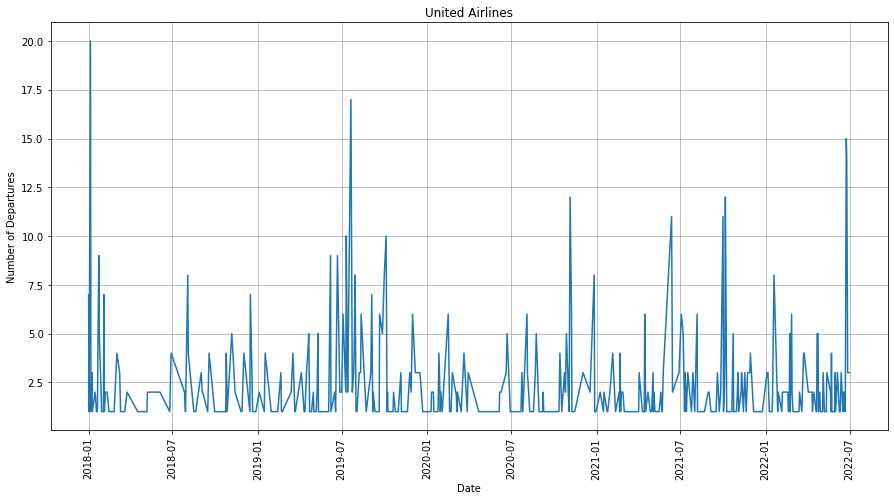

In [ ]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(UnitedAirlineActualData['Date'], UnitedAirlineActualData['Count'])
plt.title('United Airlines')
plt.ylabel('Number of Departures')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

#Auto SARIMA EVALUATION

##American Airline

In [ ]:
df = AmericanAirlineActualData.copy()
df = df[~(df['Date'] >= '2022-02-01')]
test = AmericanAirlineActualData[~(AmericanAirlineActualData['Date'] < '2022-02-01')]
#string to date format
df['Date'] = pd.to_datetime(df['Date'],infer_datetime_format=True)
df = df.set_index(['Date'])
print(df)
print(test)

           Count
Date            
2018-01-01    15
2018-01-02     1
2018-01-03     1
2018-01-05     1
2018-01-06     1
...          ...
2022-01-20     2
2022-01-21     3
2022-01-23     1
2022-01-27     8
2022-01-31     3

[425 rows x 1 columns]
          Date Count
425 2022-02-05     1
426 2022-02-06     1
427 2022-02-12     1
428 2022-02-19     1
429 2022-02-21     3
430 2022-02-22     1
431 2022-02-23     4
432 2022-02-25     1
433 2022-02-27     1
434 2022-03-01     1
435 2022-03-03     3
436 2022-03-09     4
437 2022-03-12     1
438 2022-03-13     1
439 2022-03-17     7
440 2022-03-21     1
441 2022-03-26     2
442 2022-04-02     7
443 2022-04-05     1
444 2022-04-08     1
445 2022-04-09    13
446 2022-04-11     1
447 2022-04-21     1
448 2022-04-25     6
449 2022-04-29     1
450 2022-04-30     1
451 2022-05-01     3
452 2022-05-02     4
453 2022-05-04     2
454 2022-05-09     2
455 2022-05-14     3
456 2022-05-15     6
457 2022-05-16     1
458 2022-05-24     1
459 2022-05-28    15

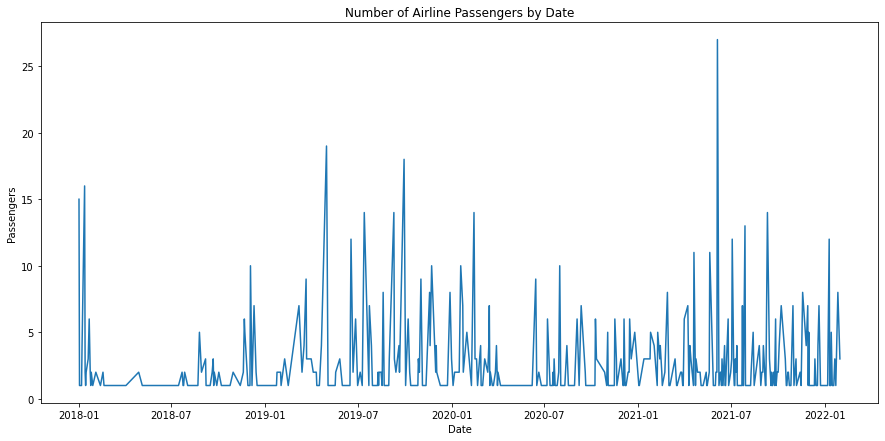

In [ ]:
plt.figure(figsize=(15,7))
plt.title("Number of Airline Passengers by Date")
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.plot(df)
plt.show()

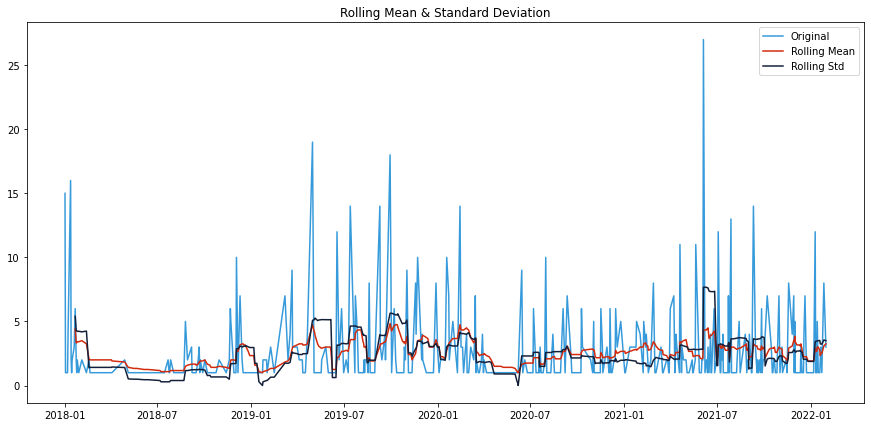

In [ ]:
#Determine rolling statistics
df["rolling_avg"] = df["Count"].rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
df["rolling_std"] = df["Count"].rolling(window=12).std()

#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(df["Count"], color='#379BDB', label='Original')
plt.plot(df["rolling_avg"], color='#D22A0D', label='Rolling Mean')
plt.plot(df["rolling_std"], color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [ ]:
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df['Count'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                 -21.681290
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    424.000000
Critical Value (1%)             -3.445867
Critical Value (5%)             -2.868381
Critical Value (10%)            -2.570414
dtype: float64


In [ ]:
#adding exogenous variable
df['month_index'] = df.index.month

# SARIMAX Model
SARIMAX_model = auto_arima(df[['Count']], exogenous=df[['month_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, 
                           trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

In [ ]:
SARIMAX_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                  425
Model:             SARIMAX(2, 1, 0, 12)   Log Likelihood               -1111.020
Date:                  Sat, 09 Jul 2022   AIC                           2230.039
Time:                          11:16:47   BIC                           2246.133
Sample:                               0   HQIC                          2236.405
                                  - 425                                         
Covariance Type:                    opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
month_index    -0.0349      0.044     -0.787      0.431      -0.122       0.052
ar.S.L12       -0.7215      0.034    -21.290      0.000      -0.788      -0.655
ar.S.L24       -0.3179      0.032    -10.083      0.000      -0.380      -0.256
sigma2         12.5011      0.441     28.324      0.000      11.636      13.366
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               881.98
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                             1.49
Prob(H) (two-sided):                  0.96   Kurtosis:                         9.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

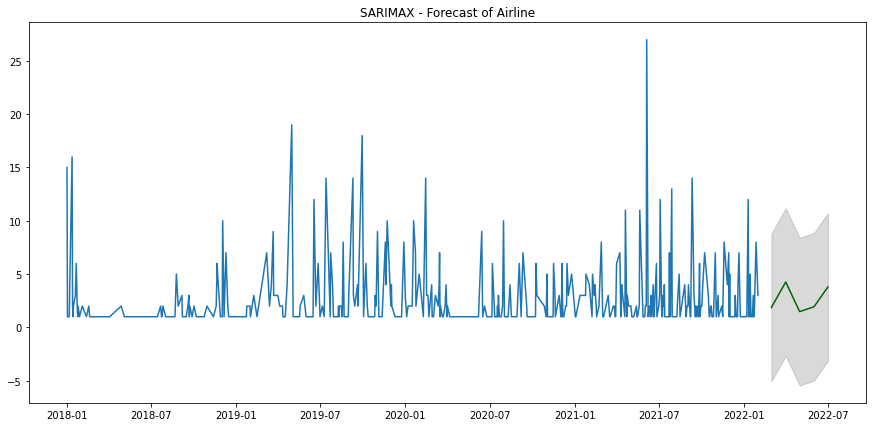

In [ ]:
def sarimax_forecast(SARIMAX_model, periods=24):
    # Forecast
    n_periods = periods

    forecast_df = pd.DataFrame({"month_index":pd.date_range(df.index[-1], periods = n_periods, freq='MS').month},
                    index = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS'))

    fitted, confint = SARIMAX_model.predict(n_periods=n_periods, 
                                            return_conf_int=True,
                                            exogenous=forecast_df[['month_index']])
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df["Count"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("SARIMAX - Forecast of Airline")
    plt.show()

    return fitted_series, df.copy()

AmericanAirlinesSARIMAForecast, AmericanAirlinesSARIMAData = sarimax_forecast(SARIMAX_model, periods=5)

In [ ]:
AmericanAirlinesSARIMAForecast

2022-03-01    1.866776
2022-04-01    4.259517
2022-05-01    1.479082
2022-06-01    1.933503
2022-07-01    3.794851
Freq: MS, dtype: float64

In [ ]:
from sklearn.metrics import mean_squared_error

y_true = [1, 7, 3, 1, 2]
y_pred = AmericanAirlinesSARIMAForecast
print(mean_squared_error(y_true, y_pred))
print(mean_squared_error(y_true, y_pred, squared=False))

2.933531325596629
1.7127554774679978


In [ ]:
AmericanAirlineSARIMAMSE = mean_squared_error(y_true, y_pred)
AmericanAirlineSARIMARMSE = mean_squared_error(y_true, y_pred, squared=False)

##Southwest Airline

In [ ]:
df = SoutwestAirlineActualData.copy()
df = df[~(df['Date'] >= '2022-02-01')]
test = SoutwestAirlineActualData[~(SoutwestAirlineActualData['Date'] < '2022-02-01')]
#string to date format
df['Date'] = pd.to_datetime(df['Date'],infer_datetime_format=True)
df = df.set_index(['Date'])
print(df)
print(test)

           Count
Date            
2018-01-01     6
2018-01-03     2
2018-01-06     2
2018-01-07     1
2018-01-20     4
...          ...
2022-01-15     1
2022-01-16     5
2022-01-19     5
2022-01-20     3
2022-01-29     2

[298 rows x 1 columns]
          Date Count
298 2022-02-01     3
299 2022-02-05     4
300 2022-02-13     2
301 2022-02-18     7
302 2022-02-21     1
303 2022-02-25     1
304 2022-02-27     3
305 2022-03-01     1
306 2022-03-02     4
307 2022-03-09     3
308 2022-03-12     1
309 2022-03-15     5
310 2022-03-19     6
311 2022-03-20     3
312 2022-03-22     1
313 2022-03-25     1
314 2022-04-05     2
315 2022-04-11     2
316 2022-04-21     2
317 2022-04-22     3
318 2022-04-23     3
319 2022-04-24     1
320 2022-04-30     4
321 2022-05-04     2
322 2022-05-08     2
323 2022-05-09     4
324 2022-05-10     1
325 2022-05-13     2
326 2022-05-16     1
327 2022-05-17     1
328 2022-05-18     2
329 2022-05-21     2
330 2022-05-26     2
331 2022-05-31     6
332 2022-06-06     2

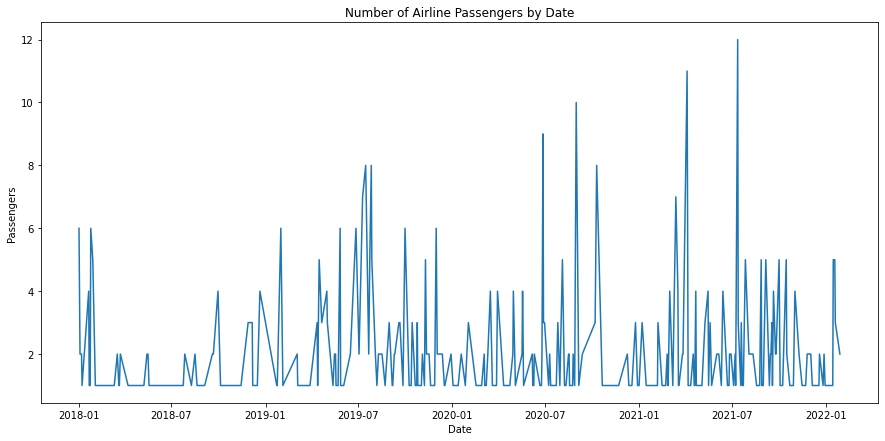

In [ ]:
plt.figure(figsize=(15,7))
plt.title("Number of Airline Passengers by Date")
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.plot(df)
plt.show()

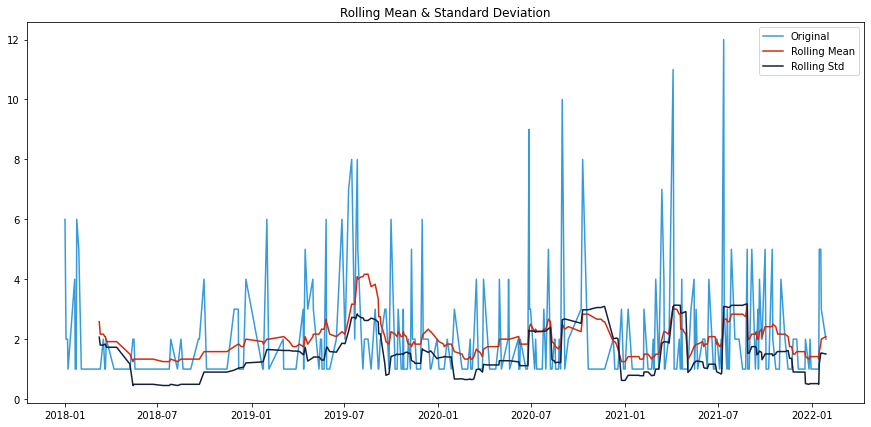

In [ ]:
#Determine rolling statistics
df["rolling_avg"] = df["Count"].rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
df["rolling_std"] = df["Count"].rolling(window=12).std()

#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(df["Count"], color='#379BDB', label='Original')
plt.plot(df["rolling_avg"], color='#D22A0D', label='Rolling Mean')
plt.plot(df["rolling_std"], color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [ ]:
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df['Count'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                -1.664889e+01
p-value                        1.610494e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.970000e+02
Critical Value (1%)           -3.452561e+00
Critical Value (5%)           -2.871321e+00
Critical Value (10%)          -2.571982e+00
dtype: float64


In [ ]:
#adding exogenous variable
df['month_index'] = df.index.month

# SARIMAX Model
SARIMAX_model = auto_arima(df[['Count']], exogenous=df[['month_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, 
                           trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

In [ ]:
SARIMAX_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                  298
Model:             SARIMAX(2, 1, 0, 12)   Log Likelihood                -609.171
Date:                  Sat, 09 Jul 2022   AIC                           1226.342
Time:                          11:17:30   BIC                           1240.966
Sample:                               0   HQIC                          1232.204
                                  - 298                                         
Covariance Type:                    opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
month_index    -0.0413      0.034     -1.233      0.218      -0.107       0.024
ar.S.L12       -0.6198      0.042    -14.899      0.000      -0.701      -0.538
ar.S.L24       -0.3648      0.039     -9.365      0.000      -0.441      -0.288
sigma2          4.0568      0.218     18.571      0.000       3.629       4.485
===================================================================================
Ljung-Box (L1) (Q):                   0.67   Jarque-Bera (JB):               201.37
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):               1.08   Skew:                             1.17
Prob(H) (two-sided):                  0.70   Kurtosis:                         6.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

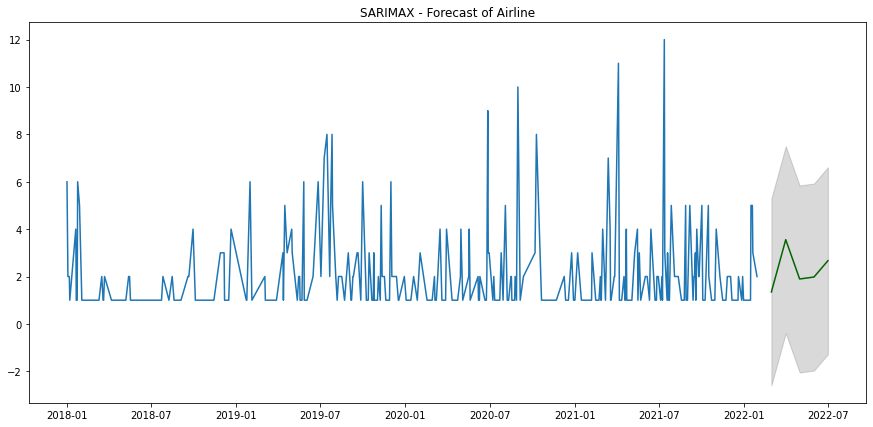

In [ ]:
def sarimax_forecast(SARIMAX_model, periods=24):
    # Forecast
    n_periods = periods

    forecast_df = pd.DataFrame({"month_index":pd.date_range(df.index[-1], periods = n_periods, freq='MS').month},
                    index = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS'))

    fitted, confint = SARIMAX_model.predict(n_periods=n_periods, 
                                            return_conf_int=True,
                                            exogenous=forecast_df[['month_index']])
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df["Count"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("SARIMAX - Forecast of Airline")
    plt.show()

    return fitted_series, df.copy()

SouthwestAirlinesSARIMAForecast, SouthwestAirlinesSARIMAData = sarimax_forecast(SARIMAX_model, periods=5)

In [ ]:
SouthwestAirlinesSARIMAForecast

2022-03-01    1.346975
2022-04-01    3.555789
2022-05-01    1.894658
2022-06-01    1.978542
2022-07-01    2.666540
Freq: MS, dtype: float64

In [ ]:
from sklearn.metrics import mean_squared_error

y_true = [1, 2, 2, 2, 2]
y_pred = SouthwestAirlinesSARIMAForecast
print(mean_squared_error(y_true, y_pred))
print(mean_squared_error(y_true, y_pred, squared=False))

0.5993407978243029
0.7741710391278551


In [ ]:
SouthwestAirlineSARIMAMSE = mean_squared_error(y_true, y_pred)
SouthwestAirlineSARIMARMSE = mean_squared_error(y_true, y_pred, squared=False)

##Delta Airline

In [ ]:
df = DeltaAirlineActualData.copy()
df = df[~(df['Date'] >= '2022-02-01')]
test = DeltaAirlineActualData[~(DeltaAirlineActualData['Date'] < '2022-02-01')]
#string to date format
df['Date'] = pd.to_datetime(df['Date'],infer_datetime_format=True)
df = df.set_index(['Date'])
print(df)
print(test)

           Count
Date            
2018-01-01     3
2018-01-02     1
2018-01-03     3
2018-01-05     1
2018-01-06     1
...          ...
2022-01-18     1
2022-01-20     1
2022-01-23     1
2022-01-26     1
2022-01-27     2

[382 rows x 1 columns]
          Date Count
382 2022-02-05     3
383 2022-02-11     3
384 2022-02-17     2
385 2022-02-19     6
386 2022-02-24     2
..         ...   ...
442 2022-06-25     3
443 2022-06-26     1
444 2022-06-27     2
445 2022-06-30    14
446 2022-07-01    18

[65 rows x 2 columns]


In [ ]:
test.head(30)

,Date,Count
382,2022-02-05,3
383,2022-02-11,3
384,2022-02-17,2
385,2022-02-19,6
386,2022-02-24,2
387,2022-02-27,3
388,2022-02-28,1
389,2022-03-05,3
390,2022-03-09,1
391,2022-03-12,1


In [ ]:
test.tail(35)

,Date,Count
412,2022-04-26,3
413,2022-04-28,2
414,2022-05-02,1
415,2022-05-03,1
416,2022-05-04,1
417,2022-05-08,4
418,2022-05-09,3
419,2022-05-11,3
420,2022-05-17,1
421,2022-05-19,4


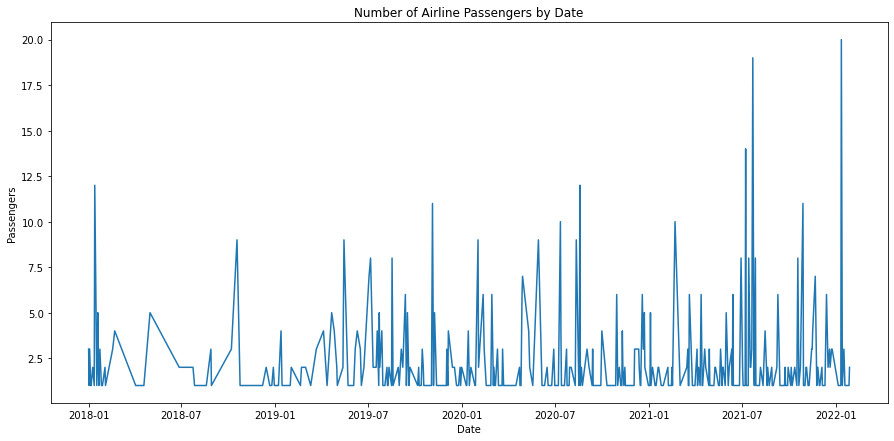

In [ ]:
plt.figure(figsize=(15,7))
plt.title("Number of Airline Passengers by Date")
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.plot(df)
plt.show()

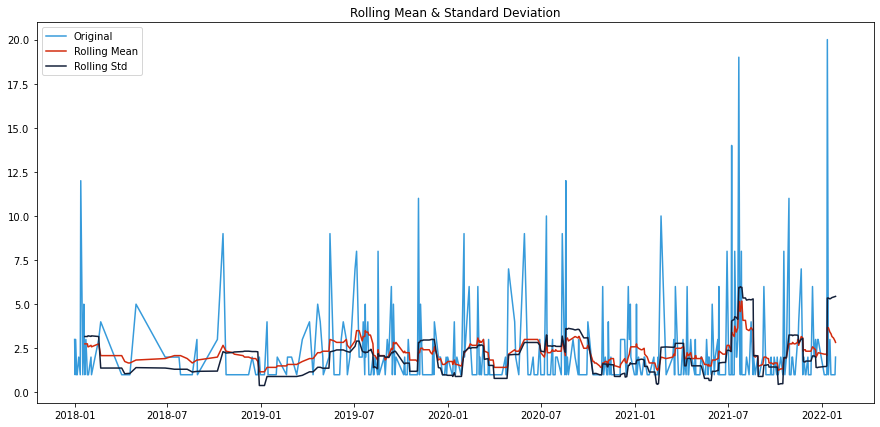

In [ ]:
#Determine rolling statistics
df["rolling_avg"] = df["Count"].rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
df["rolling_std"] = df["Count"].rolling(window=12).std()

#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(df["Count"], color='#379BDB', label='Original')
plt.plot(df["rolling_avg"], color='#D22A0D', label='Rolling Mean')
plt.plot(df["rolling_std"], color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [ ]:
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df['Count'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                 -21.226927
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    381.000000
Critical Value (1%)             -3.447631
Critical Value (5%)             -2.869156
Critical Value (10%)            -2.570827
dtype: float64


In [ ]:
#adding exogenous variable
df['month_index'] = df.index.month

# SARIMAX Model
SARIMAX_model = auto_arima(df[['Count']], exogenous=df[['month_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, 
                           trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

In [ ]:
SARIMAX_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  382
Model:             SARIMAX(0, 0, 1)x(2, 1, [], 12)   Log Likelihood                -911.234
Date:                             Sat, 09 Jul 2022   AIC                           1832.468
Time:                                     11:19:07   BIC                           1852.036
Sample:                                          0   HQIC                          1840.241
                                             - 382                                         
Covariance Type:                               opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
month_index    -0.0450      0.028     -1.607      0.108      -0.100       0.010
ma.L1          -0.0750      0.076     -0.991      0.322      -0.223       0.073
ar.S.L12       -0.7109      0.048    -14.688      0.000      -0.806      -0.616
ar.S.L24       -0.3747      0.047     -8.007      0.000      -0.466      -0.283
sigma2          7.9073      0.253     31.293      0.000       7.412       8.403
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1806.32
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               2.09   Skew:                             2.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

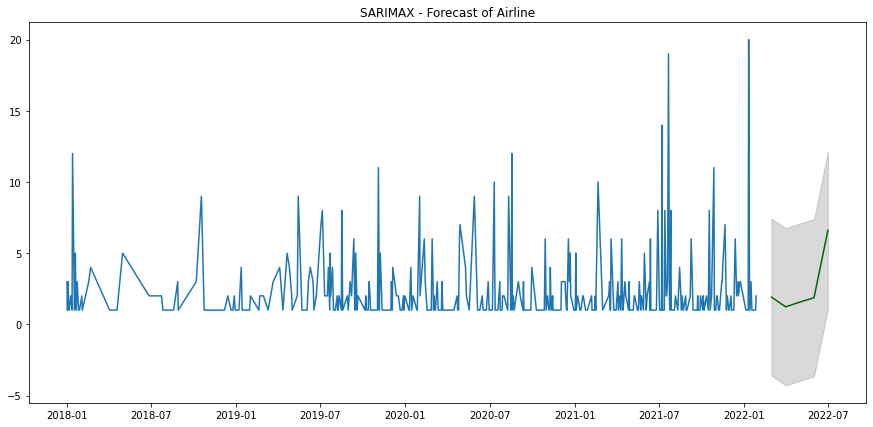

In [ ]:
def sarimax_forecast(SARIMAX_model, periods=24):
    # Forecast
    n_periods = periods

    forecast_df = pd.DataFrame({"month_index":pd.date_range(df.index[-1], periods = n_periods, freq='MS').month},
                    index = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS'))

    fitted, confint = SARIMAX_model.predict(n_periods=n_periods, 
                                            return_conf_int=True,
                                            exogenous=forecast_df[['month_index']])
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df["Count"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("SARIMAX - Forecast of Airline")
    plt.show()

    return fitted_series, df.copy()

DeltaAirlinesSARIMAForecast, DeltaAirlinesSARIMAData = sarimax_forecast(SARIMAX_model, periods=5)

In [ ]:
DeltaAirlinesSARIMAForecast

2022-03-01    1.911684
2022-04-01    1.230038
2022-05-01    1.559692
2022-06-01    1.866023
2022-07-01    6.603027
Freq: MS, dtype: float64

In [ ]:
from sklearn.metrics import mean_squared_error

y_true = [3, 1, 1, 1, 18]
y_pred = round(DeltaAirlinesSARIMAForecast)
print(mean_squared_error(y_true, y_pred))
print(mean_squared_error(y_true, y_pred, squared=False))

24.8
4.979959839195493


In [ ]:
DeltaAirlineSARIMAMSE = mean_squared_error(y_true, y_pred)
DeltaAirlineSARIMARMSE = mean_squared_error(y_true, y_pred, squared=False)

##United Airline

In [ ]:
df = UnitedAirlineActualData.copy()
df = df[~(df['Date'] >= '2022-02-01')]
test = UnitedAirlineActualData[~(UnitedAirlineActualData['Date'] < '2022-02-01')]
#string to date format
df['Date'] = pd.to_datetime(df['Date'],infer_datetime_format=True)
df = df.set_index(['Date'])
print(df)
print(test)

           Count
Date            
2018-01-01     7
2018-01-02     1
2018-01-05    20
2018-01-06     1
2018-01-07     2
...          ...
2022-01-15     1
2022-01-16     2
2022-01-19     8
2022-01-27     1
2022-01-28     2

[354 rows x 1 columns]
          Date Count
354 2022-02-05     1
355 2022-02-06     2
356 2022-02-18     2
357 2022-02-19     1
358 2022-02-21     1
359 2022-02-22     5
360 2022-02-23     1
361 2022-02-26     6
362 2022-02-27     2
363 2022-03-01     1
364 2022-03-04     1
365 2022-03-13     1
366 2022-03-14     1
367 2022-03-15     2
368 2022-03-20     1
369 2022-03-24     4
370 2022-03-25     4
371 2022-04-03     2
372 2022-04-11     2
373 2022-04-12     1
374 2022-04-15     2
375 2022-04-20     1
376 2022-04-21     1
377 2022-04-22     5
378 2022-04-24     5
379 2022-04-25     1
380 2022-04-28     2
381 2022-04-29     1
382 2022-04-30     1
383 2022-05-04     1
384 2022-05-05     3
385 2022-05-08     1
386 2022-05-09     1
387 2022-05-12     1
388 2022-05-13     3

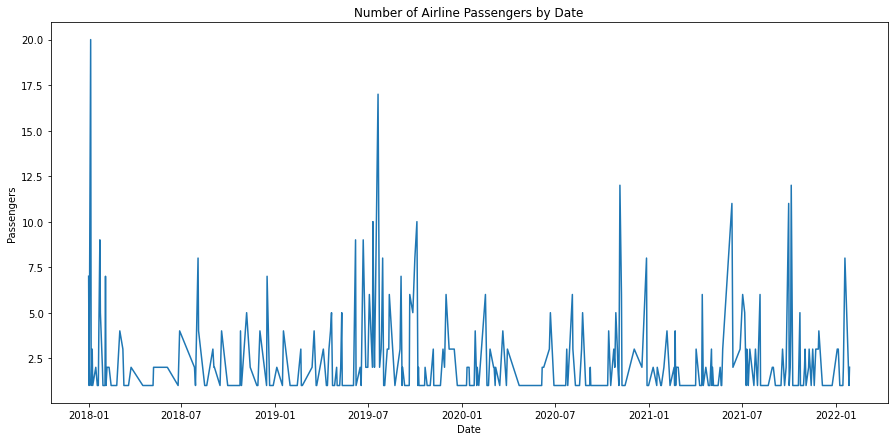

In [ ]:
plt.figure(figsize=(15,7))
plt.title("Number of Airline Passengers by Date")
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.plot(df)
plt.show()

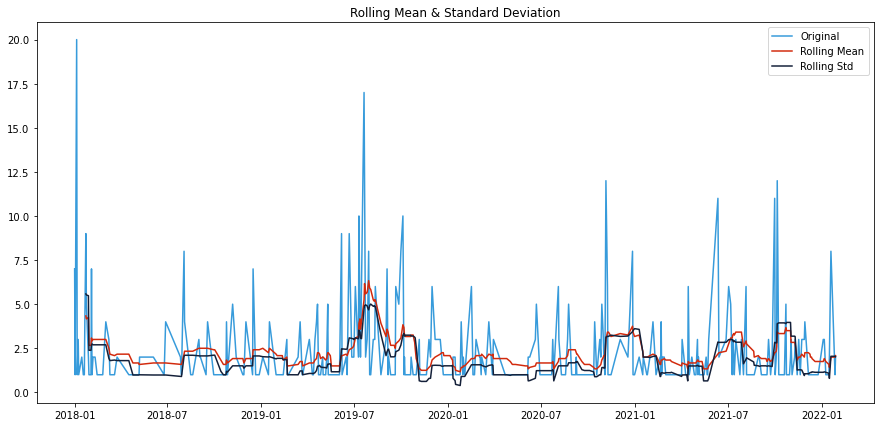

In [ ]:
#Determine rolling statistics
df["rolling_avg"] = df["Count"].rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
df["rolling_std"] = df["Count"].rolling(window=12).std()

#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(df["Count"], color='#379BDB', label='Original')
plt.plot(df["rolling_avg"], color='#D22A0D', label='Rolling Mean')
plt.plot(df["rolling_std"], color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [ ]:
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df['Count'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                -7.319785e+00
p-value                        1.202588e-10
#Lags Used                     3.000000e+00
Number of Observations Used    3.500000e+02
Critical Value (1%)           -3.449173e+00
Critical Value (5%)           -2.869833e+00
Critical Value (10%)          -2.571188e+00
dtype: float64


In [ ]:
#adding exogenous variable
df['month_index'] = df.index.month

# SARIMAX Model
SARIMAX_model = auto_arima(df[['Count']], exogenous=df[['month_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, 
                           trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

In [ ]:
SARIMAX_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  354
Model:             SARIMAX(1, 0, 1)x(2, 1, [], 12)   Log Likelihood                -834.482
Date:                             Sat, 09 Jul 2022   AIC                           1680.964
Time:                                     11:20:32   BIC                           1703.973
Sample:                                          0   HQIC                          1690.130
                                             - 354                                         
Covariance Type:                               opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
month_index     0.0137      0.059      0.232      0.817      -0.102       0.130
ar.L1           0.8844      0.094      9.369      0.000       0.699       1.069
ma.L1          -0.7955      0.120     -6.650      0.000      -1.030      -0.561
ar.S.L12       -0.6883      0.039    -17.572      0.000      -0.765      -0.612
ar.S.L24       -0.2940      0.050     -5.890      0.000      -0.392      -0.196
sigma2          7.5724      0.334     22.661      0.000       6.917       8.227
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               547.02
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                             0.67
Prob(H) (two-sided):                  0.09   Kurtosis:                         9.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

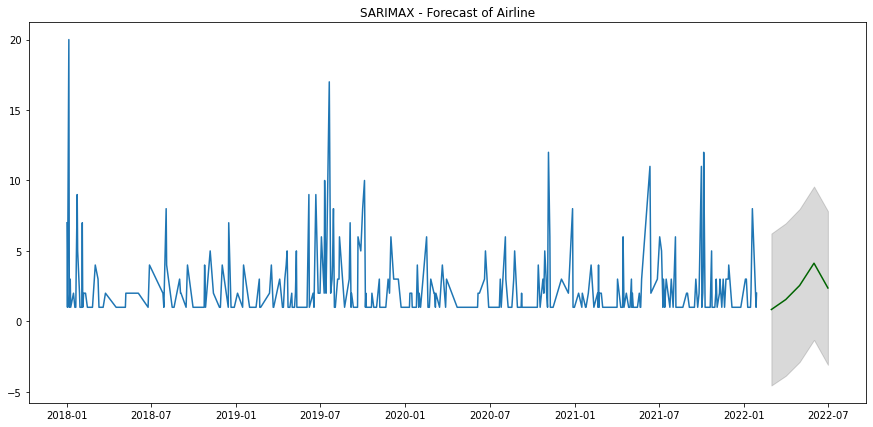

In [ ]:
def sarimax_forecast(SARIMAX_model, periods=24):
    # Forecast
    n_periods = periods

    forecast_df = pd.DataFrame({"month_index":pd.date_range(df.index[-1], periods = n_periods, freq='MS').month},
                    index = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS'))

    fitted, confint = SARIMAX_model.predict(n_periods=n_periods, 
                                            return_conf_int=True,
                                            exogenous=forecast_df[['month_index']])
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df["Count"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("SARIMAX - Forecast of Airline")
    plt.show()

    return fitted_series, df.copy()

UnitedAirlinesSARIMAForecast, UnitedAirlinesSARIMAData = sarimax_forecast(SARIMAX_model, periods=5)

In [ ]:
UnitedAirlinesSARIMAForecast

2022-03-01    0.841968
2022-04-01    1.547973
2022-05-01    2.547535
2022-06-01    4.127911
2022-07-01    2.369020
Freq: MS, dtype: float64

In [ ]:
from sklearn.metrics import mean_squared_error

y_true = [1, 2, 1, 1, 3]
y_pred = UnitedAirlinesSARIMAForecast
print(mean_squared_error(y_true, y_pred))
print(mean_squared_error(y_true, y_pred, squared=False))

2.5612260671042746
1.6003831001058073


In [ ]:
UnitedAirlineSARIMAMSE = mean_squared_error(y_true, y_pred)
UnitedAirlineSARIMARMSE = mean_squared_error(y_true, y_pred, squared=False)

#Auto SARIMA

In [ ]:
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

from statsmodels.tsa.stattools import adfuller

In [ ]:
# UnitedAirlineActualData.drop('arima_model', inplace=True, axis=1)

In [ ]:
!pip install pmdarima
from pmdarima.arima import auto_arima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##American Airline

In [ ]:
df = AmericanAirlineActualData.copy()
df = df[~(df['Date'] >= '2022-06-01')]
#string to date format
df['Date'] = pd.to_datetime(df['Date'],infer_datetime_format=True)
df = df.set_index(['Date'])
df

,Count
Date,
2018-01-01,15
2018-01-02,1
2018-01-03,1
2018-01-05,1
2018-01-06,1
...,...
2022-05-14,3
2022-05-15,6
2022-05-16,1


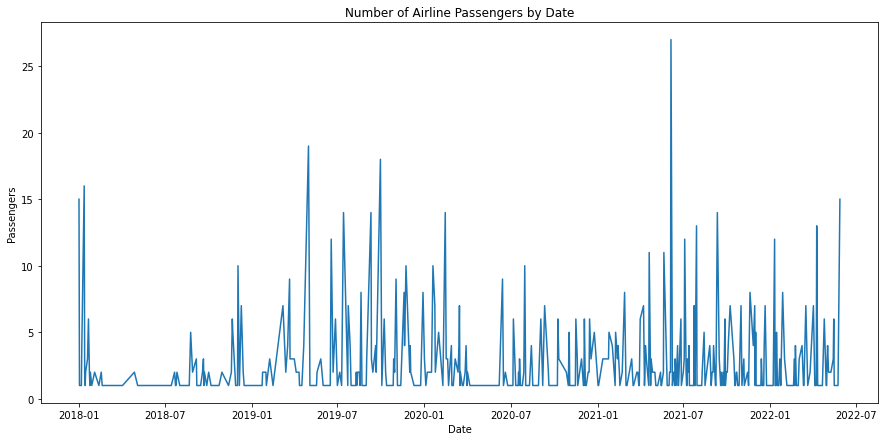

In [ ]:
plt.figure(figsize=(15,7))
plt.title("Number of Airline Passengers by Date")
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.plot(df)
plt.show()

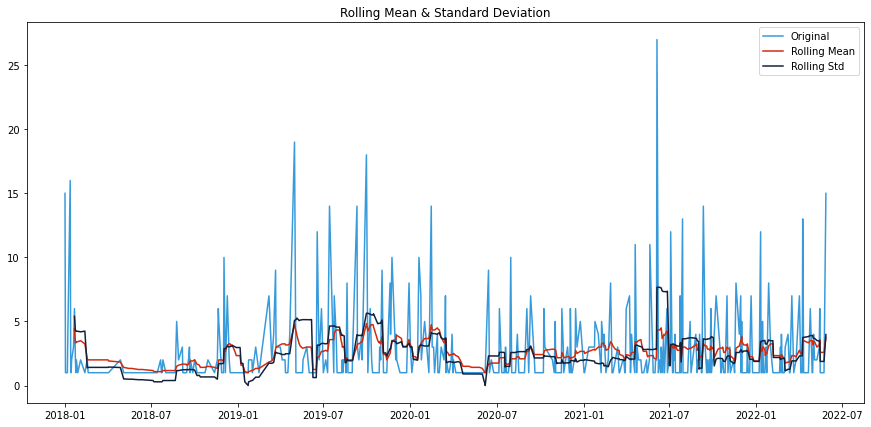

In [ ]:
#Determine rolling statistics
df["rolling_avg"] = df["Count"].rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
df["rolling_std"] = df["Count"].rolling(window=12).std()

#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(df["Count"], color='#379BDB', label='Original')
plt.plot(df["rolling_avg"], color='#D22A0D', label='Rolling Mean')
plt.plot(df["rolling_std"], color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [ ]:
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df['Count'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                 -22.487648
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    459.000000
Critical Value (1%)             -3.444677
Critical Value (5%)             -2.867857
Critical Value (10%)            -2.570135
dtype: float64


In [ ]:
#adding exogenous variable
df['month_index'] = df.index.month

# SARIMAX Model
SARIMAX_model = auto_arima(df[['Count']], exogenous=df[['month_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, 
                           trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

In [ ]:
SARIMAX_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                  460
Model:             SARIMAX(2, 1, 0, 12)   Log Likelihood               -1206.741
Date:                  Sat, 09 Jul 2022   AIC                           2421.482
Time:                          11:23:23   BIC                           2437.901
Sample:                               0   HQIC                          2427.955
                                  - 460                                         
Covariance Type:                    opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
month_index    -0.0184      0.043     -0.423      0.672      -0.104       0.067
ar.S.L12       -0.7288      0.033    -21.759      0.000      -0.794      -0.663
ar.S.L24       -0.3245      0.031    -10.566      0.000      -0.385      -0.264
sigma2         12.6006      0.438     28.755      0.000      11.742      13.459
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):               846.27
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                             1.48
Prob(H) (two-sided):                  0.67   Kurtosis:                         9.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

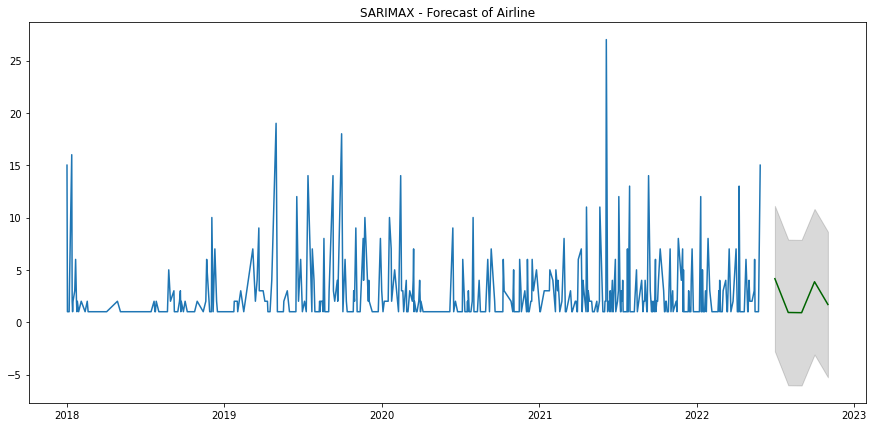

In [ ]:
def sarimax_forecast(SARIMAX_model, periods=24):
    # Forecast
    n_periods = periods

    forecast_df = pd.DataFrame({"month_index":pd.date_range(df.index[-1], periods = n_periods, freq='MS').month},
                    index = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS'))

    fitted, confint = SARIMAX_model.predict(n_periods=n_periods, 
                                            return_conf_int=True,
                                            exogenous=forecast_df[['month_index']])
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df["Count"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("SARIMAX - Forecast of Airline")
    plt.show()

    return fitted_series, df.copy()

AmericanAirlinesSARIMAForecast, AmericanAirlinesSARIMAData = sarimax_forecast(SARIMAX_model, periods=5)

In [ ]:
AmericanAirlinesSARIMAForecast

2022-07-01    4.155913
2022-08-01    0.925466
2022-09-01    0.907077
2022-10-01    3.861946
2022-11-01    1.689014
Freq: MS, dtype: float64

##Southwest Airline

In [ ]:
df = SoutwestAirlineActualData
df = df[~(df['Date'] >= '2022-06-01')]
#string to date format
df['Date'] = pd.to_datetime(df['Date'],infer_datetime_format=True)
df = df.set_index(['Date'])
df

,Count
Date,
2018-01-01,6
2018-01-03,2
2018-01-06,2
2018-01-07,1
2018-01-20,4
...,...
2022-05-17,1
2022-05-18,2
2022-05-21,2


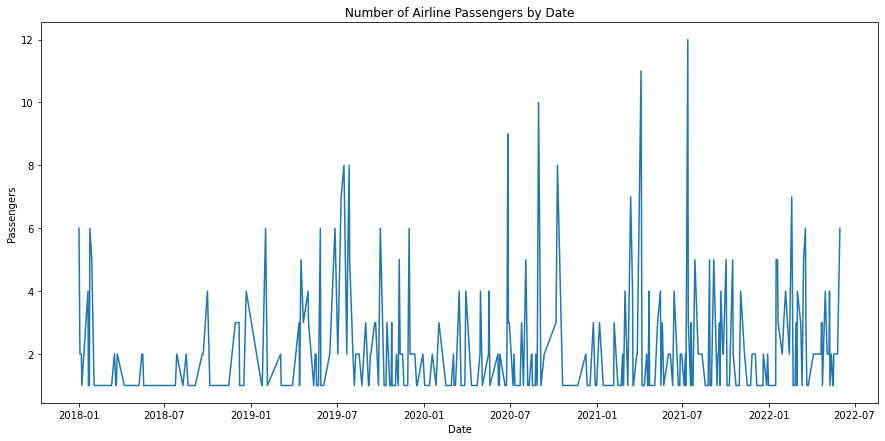

In [ ]:
plt.figure(figsize=(15,7))
plt.title("Number of Airline Passengers by Date")
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.plot(df)
plt.show()

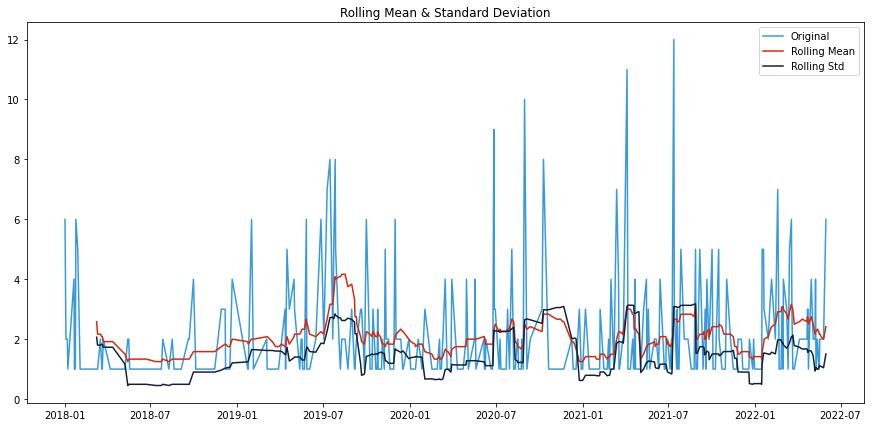

In [ ]:
#Determine rolling statistics
df["rolling_avg"] = df["Count"].rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
df["rolling_std"] = df["Count"].rolling(window=12).std()

#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(df["Count"], color='#379BDB', label='Original')
plt.plot(df["rolling_avg"], color='#D22A0D', label='Rolling Mean')
plt.plot(df["rolling_std"], color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [ ]:
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df['Count'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                -1.745624e+01
p-value                        4.623574e-30
#Lags Used                     0.000000e+00
Number of Observations Used    3.310000e+02
Critical Value (1%)           -3.450262e+00
Critical Value (5%)           -2.870312e+00
Critical Value (10%)          -2.571443e+00
dtype: float64


In [ ]:
#adding exogenous variable
df['month_index'] = df.index.month

# SARIMAX Model
SARIMAX_model = auto_arima(df[['Count']], exogenous=df[['month_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, 
                           trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

In [ ]:
SARIMAX_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                  332
Model:             SARIMAX(2, 1, 0, 12)   Log Likelihood                -677.598
Date:                  Sat, 09 Jul 2022   AIC                           1363.195
Time:                          11:24:45   BIC                           1378.268
Sample:                               0   HQIC                          1369.214
                                  - 332                                         
Covariance Type:                    opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
month_index    -0.0510      0.029     -1.755      0.079      -0.108       0.006
ar.S.L12       -0.6275      0.040    -15.855      0.000      -0.705      -0.550
ar.S.L24       -0.3726      0.037     -9.974      0.000      -0.446      -0.299
sigma2          3.9634      0.202     19.612      0.000       3.567       4.359
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):               197.52
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):               0.95   Skew:                             1.12
Prob(H) (two-sided):                  0.79   Kurtosis:                         6.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

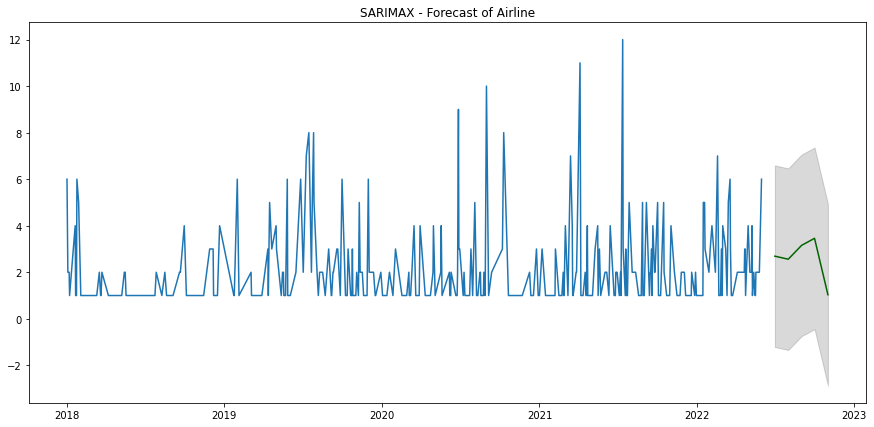

In [ ]:
def sarimax_forecast(SARIMAX_model, periods=24):
    # Forecast
    n_periods = periods

    forecast_df = pd.DataFrame({"month_index":pd.date_range(df.index[-1], periods = n_periods, freq='MS').month},
                    index = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS'))

    fitted, confint = SARIMAX_model.predict(n_periods=n_periods, 
                                            return_conf_int=True,
                                            exogenous=forecast_df[['month_index']])
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df["Count"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("SARIMAX - Forecast of Airline")
    plt.show()

    return fitted_series, df.copy()

SoutwestAirlinesSARIMAForecast, SoutwestAirlinesSARIMAData = sarimax_forecast(SARIMAX_model, periods=5)

In [ ]:
SoutwestAirlinesSARIMAForecast

2022-07-01    2.690579
2022-08-01    2.560580
2022-09-01    3.156057
2022-10-01    3.457907
2022-11-01    1.034370
Freq: MS, dtype: float64

##Delta Airline

In [ ]:
df = DeltaAirlineActualData
df = df[~(df['Date'] >= '2022-06-01')]
#string to date format
df['Date'] = pd.to_datetime(df['Date'],infer_datetime_format=True)
df = df.set_index(['Date'])
df

,Count
Date,
2018-01-01,3
2018-01-02,1
2018-01-03,3
2018-01-05,1
2018-01-06,1
...,...
2022-05-26,6
2022-05-27,9
2022-05-28,2


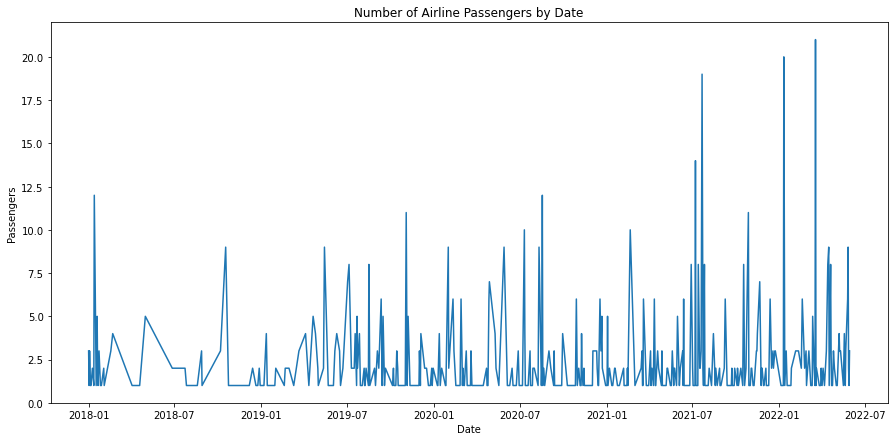

In [ ]:
plt.figure(figsize=(15,7))
plt.title("Number of Airline Passengers by Date")
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.plot(df)
plt.show()

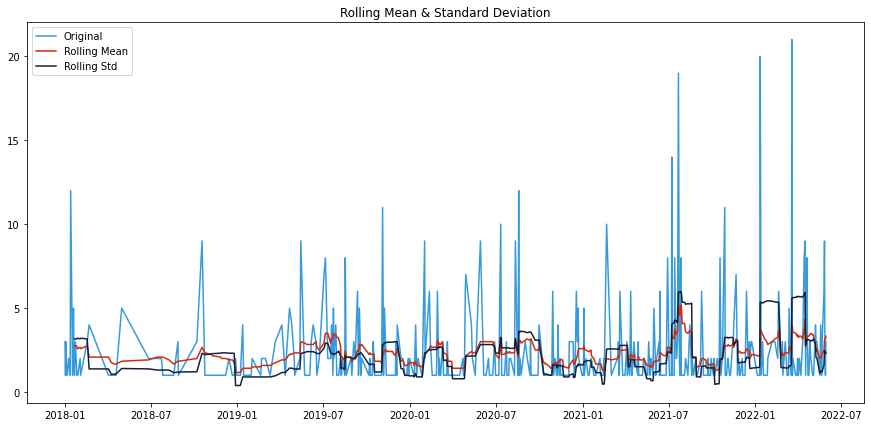

In [ ]:
#Determine rolling statistics
df["rolling_avg"] = df["Count"].rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
df["rolling_std"] = df["Count"].rolling(window=12).std()

#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(df["Count"], color='#379BDB', label='Original')
plt.plot(df["rolling_avg"], color='#D22A0D', label='Rolling Mean')
plt.plot(df["rolling_std"], color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [ ]:
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df['Count'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                 -22.153664
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    428.000000
Critical Value (1%)             -3.445721
Critical Value (5%)             -2.868317
Critical Value (10%)            -2.570380
dtype: float64


In [ ]:
#adding exogenous variable
df['month_index'] = df.index.month

# SARIMAX Model
SARIMAX_model = auto_arima(df[['Count']], exogenous=df[['month_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, 
                           trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

In [ ]:
SARIMAX_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  429
Model:             SARIMAX(0, 0, 1)x(2, 1, [], 12)   Log Likelihood               -1054.101
Date:                             Sat, 09 Jul 2022   AIC                           2118.203
Time:                                     11:25:54   BIC                           2138.368
Sample:                                          0   HQIC                          2126.175
                                             - 429                                         
Covariance Type:                               opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
month_index    -0.0474      0.031     -1.531      0.126      -0.108       0.013
ma.L1          -0.0728      0.067     -1.081      0.280      -0.205       0.059
ar.S.L12       -0.7036      0.037    -18.813      0.000      -0.777      -0.630
ar.S.L24       -0.3880      0.037    -10.624      0.000      -0.460      -0.316
sigma2          9.0233      0.268     33.653      0.000       8.498       9.549
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2137.88
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               2.58   Skew:                             2.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

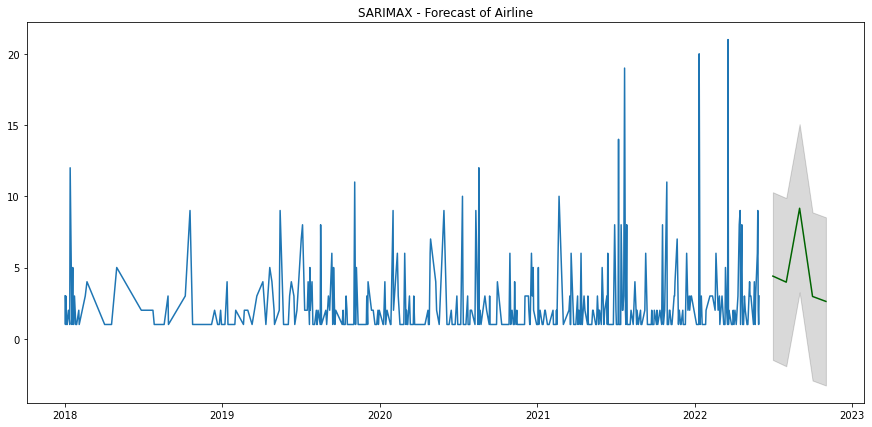

In [ ]:
def sarimax_forecast(SARIMAX_model, periods=24):
    # Forecast
    n_periods = periods

    forecast_df = pd.DataFrame({"month_index":pd.date_range(df.index[-1], periods = n_periods, freq='MS').month},
                    index = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS'))

    fitted, confint = SARIMAX_model.predict(n_periods=n_periods, 
                                            return_conf_int=True,
                                            exogenous=forecast_df[['month_index']])
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df["Count"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("SARIMAX - Forecast of Airline")
    plt.show()

    return fitted_series, df.copy()

DeltaAirlinesSARIMAForecast, DeltaAirlinesSARIMAData = sarimax_forecast(SARIMAX_model, periods=5)

In [ ]:
DeltaAirlinesSARIMAForecast

2022-07-01    4.396010
2022-08-01    3.970979
2022-09-01    9.158535
2022-10-01    2.967680
2022-11-01    2.619367
Freq: MS, dtype: float64

##United Airline

In [ ]:
df = UnitedAirlineActualData
df = df[~(df['Date'] >= '2022-06-01')]
#string to date format
df['Date'] = pd.to_datetime(df['Date'],infer_datetime_format=True)
df = df.set_index(['Date'])
df

,Count
Date,
2018-01-01,7
2018-01-02,1
2018-01-05,20
2018-01-06,1
2018-01-07,2
...,...
2022-05-22,1
2022-05-23,4
2022-05-24,1


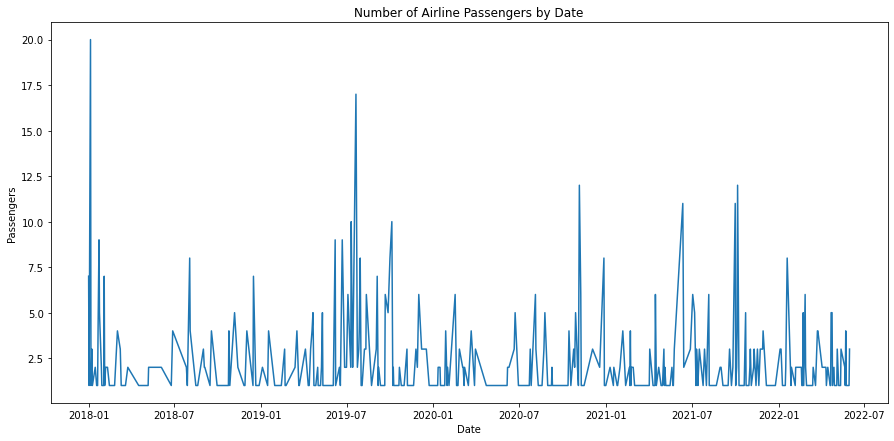

In [ ]:
plt.figure(figsize=(15,7))
plt.title("Number of Airline Passengers by Date")
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.plot(df)
plt.show()

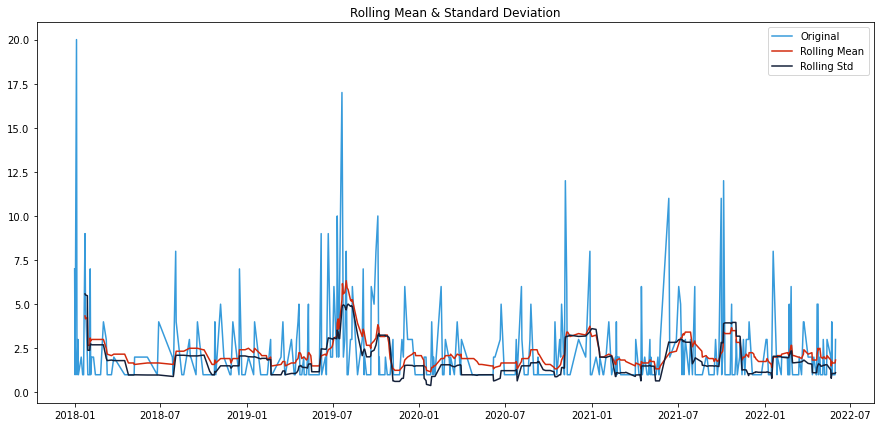

In [ ]:
#Determine rolling statistics
df["rolling_avg"] = df["Count"].rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
df["rolling_std"] = df["Count"].rolling(window=12).std()

#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(df["Count"], color='#379BDB', label='Original')
plt.plot(df["rolling_avg"], color='#D22A0D', label='Rolling Mean')
plt.plot(df["rolling_std"], color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [ ]:
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df['Count'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                -7.931224e+00
p-value                        3.508845e-12
#Lags Used                     3.000000e+00
Number of Observations Used    3.910000e+02
Critical Value (1%)           -3.447186e+00
Critical Value (5%)           -2.868960e+00
Critical Value (10%)          -2.570723e+00
dtype: float64


In [ ]:
#adding exogenous variable
df['month_index'] = df.index.month

# SARIMAX Model
SARIMAX_model = auto_arima(df[['Count']], exogenous=df[['month_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, 
                           trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

In [ ]:
SARIMAX_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  395
Model:             SARIMAX(1, 0, 1)x(2, 1, [], 12)   Log Likelihood                -922.512
Date:                             Sat, 09 Jul 2022   AIC                           1857.024
Time:                                     11:27:21   BIC                           1880.712
Sample:                                          0   HQIC                          1866.421
                                             - 395                                         
Covariance Type:                               opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
month_index     0.0099      0.054      0.184      0.854      -0.095       0.115
ar.L1           0.8835      0.092      9.561      0.000       0.702       1.065
ma.L1          -0.8005      0.116     -6.913      0.000      -1.027      -0.574
ar.S.L12       -0.6906      0.036    -19.054      0.000      -0.762      -0.620
ar.S.L24       -0.2905      0.046     -6.340      0.000      -0.380      -0.201
sigma2          7.1253      0.292     24.373      0.000       6.552       7.698
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):               652.28
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                             0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

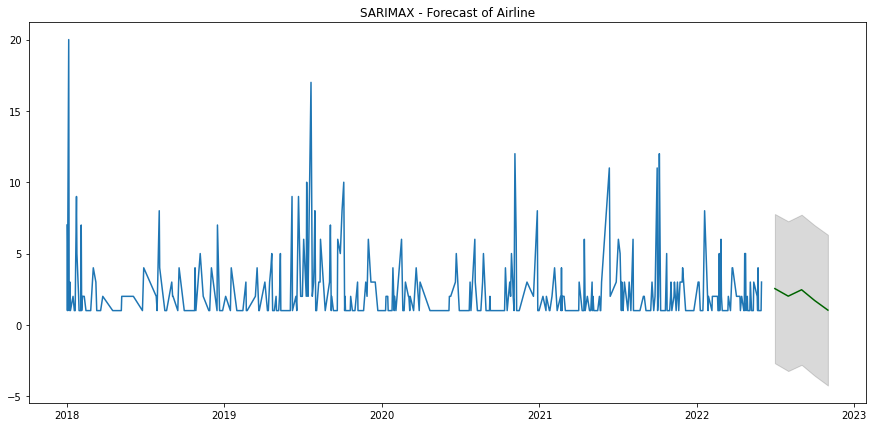

In [ ]:
def sarimax_forecast(SARIMAX_model, periods=24):
    # Forecast
    n_periods = periods

    forecast_df = pd.DataFrame({"month_index":pd.date_range(df.index[-1], periods = n_periods, freq='MS').month},
                    index = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS'))

    fitted, confint = SARIMAX_model.predict(n_periods=n_periods, 
                                            return_conf_int=True,
                                            exogenous=forecast_df[['month_index']])
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # UnitedAirlinesSARIMAForecast = fitted_series.copy(deep=True)

    UnitedAirlinesSARIMAData = df.copy()

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df["Count"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("SARIMAX - Forecast of Airline")
    plt.show()

    return fitted_series, df.copy()

UnitedAirlinesSARIMAForecast, UnitedAirlinesSARIMAData = sarimax_forecast(SARIMAX_model, periods=5)

##DATA

In [ ]:
print(AmericanAirlinesSARIMAForecast)
print(SoutwestAirlinesSARIMAForecast)
print(DeltaAirlinesSARIMAForecast)
print(UnitedAirlinesSARIMAForecast)

2022-07-01    4.155913
2022-08-01    0.925466
2022-09-01    0.907077
2022-10-01    3.861946
2022-11-01    1.689014
Freq: MS, dtype: float64
2022-07-01    2.690579
2022-08-01    2.560580
2022-09-01    3.156057
2022-10-01    3.457907
2022-11-01    1.034370
Freq: MS, dtype: float64
2022-07-01    4.396010
2022-08-01    3.970979
2022-09-01    9.158535
2022-10-01    2.967680
2022-11-01    2.619367
Freq: MS, dtype: float64
2022-07-01    2.541047
2022-08-01    2.012618
2022-09-01    2.460829
2022-10-01    1.712601
2022-11-01    1.032494
Freq: MS, dtype: float64


#facebook prophet

In [ ]:
print(AmericanAirlineActualData)
print(SoutwestAirlineActualData)
print(DeltaAirlineActualData)
print(UnitedAirlineActualData)

          Date Count
0   2018-01-01    15
1   2018-01-02     1
2   2018-01-03     1
3   2018-01-05     1
4   2018-01-06     1
..         ...   ...
475 2022-06-25     1
476 2022-06-27     2
477 2022-06-28     1
478 2022-06-30     1
479 2022-07-01     2

[480 rows x 2 columns]
          Date Count
0   2018-01-01     6
1   2018-01-03     2
2   2018-01-06     2
3   2018-01-07     1
4   2018-01-20     4
..         ...   ...
338 2022-06-23     1
339 2022-06-24     1
340 2022-06-25    14
341 2022-06-27     3
342 2022-07-01     2

[343 rows x 2 columns]
          Date Count
0   2018-01-01     3
1   2018-01-02     1
2   2018-01-03     3
3   2018-01-05     1
4   2018-01-06     1
..         ...   ...
442 2022-06-25     3
443 2022-06-26     1
444 2022-06-27     2
445 2022-06-30    14
446 2022-07-01    18

[447 rows x 2 columns]
          Date Count
0   2018-01-01     7
1   2018-01-02     1
2   2018-01-05    20
3   2018-01-06     1
4   2018-01-07     2
..         ...   ...
407 2022-06-24    15
408 

##Custom Holidays

In [ ]:
ds = pd.date_range('2018-01-01', '2023-12-31', freq='D').to_series()
dOw = pd.date_range('2018-01-01', '2023-12-31', freq='D').to_series().dt.dayofweek

weekends = pd.DataFrame(columns=['holiday', 'ds'])

dsArr = []

for i in range(len(ds)):
  if dOw[i] > 4:
    dsArr.append(ds[i])

In [ ]:
weekends['ds'] = dsArr
weekends['holiday'] = "weekend"

In [ ]:
weekends

,holiday,ds
0,weekend,2018-01-06
1,weekend,2018-01-07
2,weekend,2018-01-13
3,weekend,2018-01-14
4,weekend,2018-01-20
...,...,...
621,weekend,2023-12-17
622,weekend,2023-12-23
623,weekend,2023-12-24
624,weekend,2023-12-30


##American Airline

###Check Accuracy

In [ ]:
# make an in-of-sample forecast
from pandas import read_csv
from pandas import to_datetime
from pandas import DataFrame
from fbprophet import Prophet
from matplotlib import pyplot

In [ ]:
# load data
dfUnclean = AmericanAirlineActualData.copy()
# prepare expected column names
df = pd.DataFrame(columns=['ds', 'y'])
df['ds'] = to_datetime(dfUnclean['Date'])
df['y'] = dfUnclean['Count']

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds      yhat  yhat_lower  yhat_upper
0 2021-07-01  1.655005   -2.046335    5.575252
1 2021-08-01  2.256255   -1.526004    5.824240
2 2021-09-01  2.604577   -1.413733    6.425267
3 2021-10-01  3.263244   -0.651831    7.035354
4 2021-11-01  2.498489   -1.203626    6.727343


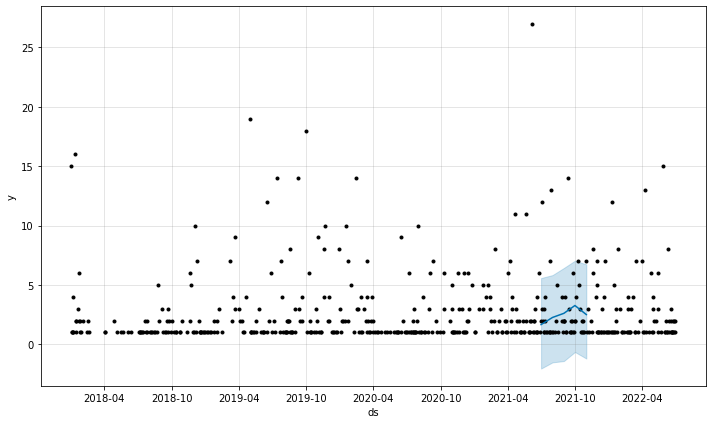

In [ ]:
import holidays
# define the model
model = Prophet(holidays = weekends)
model.add_country_holidays(country_name='US')
# fit the model
model.fit(df)
# define the period for which we want a prediction
future = list()
for i in range(7, 12):
	date = '2021-%02d' % i
	future.append([date])
future = DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])
# use the model to make a forecast
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
pyplot.show()

In [ ]:
from sklearn.metrics import mean_squared_error

testing = df[~(df['ds'] < '2021-07-01')]
testing = testing[~(testing['ds'] > '2021-12-01')]
y_true = [2, 1, 2, 2, 1]
y_pred = forecast['yhat']
print(mean_squared_error(y_true, y_pred))
print(mean_squared_error(y_true, y_pred, squared=False))

AmericanAirlineProphetMSE = mean_squared_error(y_true, y_pred)
AmericanAirlineProphetRMSE = mean_squared_error(y_true, y_pred, squared=False)


1.180792801496637
1.086642904314309


In [ ]:
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon = '150 days')


df_p = performance_metrics(df_cv)
df_p

INFO:fbprophet:Making 5 forecasts with cutoffs between 2020-02-12 00:00:00 and 2022-02-01 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

,horizon,mse,rmse,mae,mape,mdape,coverage
0,19 days,10.095695,3.177372,2.199982,1.439163,1.157940,0.88
1,20 days,7.523439,2.742889,2.007008,1.439136,1.157940,0.90
2,21 days,5.942039,2.437630,1.926713,1.393233,0.718369,0.88
3,22 days,5.963265,2.441980,1.938897,1.364794,0.718369,0.88
4,23 days,6.383102,2.526480,2.053993,1.360033,0.746022,0.88
...,...,...,...,...,...,...,...
110,146 days,5.362152,2.315632,1.976224,1.340006,1.032460,0.88
111,147 days,4.791392,2.188925,1.840744,1.250914,1.032460,0.88
112,148 days,8.961859,2.993636,2.162207,1.231797,1.032460,0.84
113,149 days,8.747036,2.957539,2.108348,1.223588,1.032460,0.84


###Actual Forecast

In [ ]:
# make an out-of-sample forecast
from pandas import read_csv
from pandas import to_datetime
from pandas import DataFrame
from fbprophet import Prophet
from matplotlib import pyplot

In [ ]:
# load data
dfUnclean = AmericanAirlineActualData.copy()
# prepare expected column names
df = pd.DataFrame(columns=['ds', 'y'])
df['ds'] = to_datetime(dfUnclean['Date'])
df['y'] = dfUnclean['Count']

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds      yhat  yhat_lower  yhat_upper
0 2022-07-01  2.269811   -1.757935    6.150743
1 2022-08-01  3.039603   -0.929125    6.697261
2 2022-09-01  3.162406   -0.790659    6.867190
3 2022-10-01  3.517173    0.044039    7.373235
4 2022-11-01  1.839747   -2.043582    5.891483


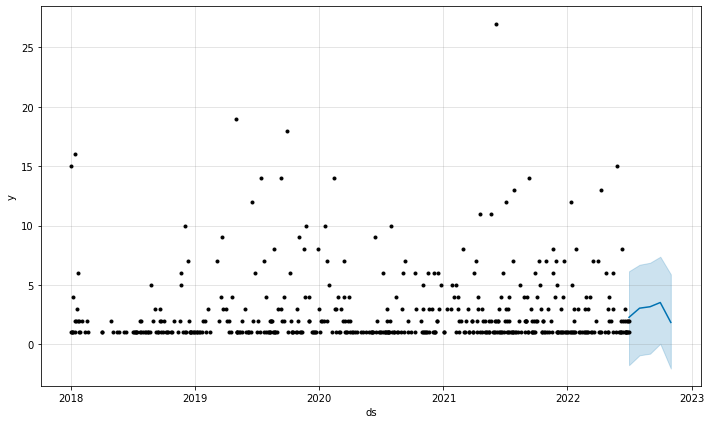

In [ ]:
import holidays
# define the model
model = Prophet(holidays = weekends)
model.add_country_holidays(country_name='US')
# fit the model
model.fit(df)
# define the period for which we want a prediction
future = list()
for i in range(7, 12):
	date = '2022-%02d' % i
	future.append([date])
future = DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])
# use the model to make a forecast
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
pyplot.show()

In [ ]:
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon = '150 days')


df_p = performance_metrics(df_cv)
df_p

INFO:fbprophet:Making 5 forecasts with cutoffs between 2020-02-12 00:00:00 and 2022-02-01 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

,horizon,mse,rmse,mae,mape,mdape,coverage
0,19 days,10.095695,3.177372,2.199982,1.439163,1.157940,0.88
1,20 days,7.523439,2.742889,2.007008,1.439136,1.157940,0.90
2,21 days,5.942039,2.437630,1.926713,1.393233,0.718369,0.88
3,22 days,5.963265,2.441980,1.938897,1.364794,0.718369,0.88
4,23 days,6.383102,2.526480,2.053993,1.360033,0.746022,0.88
...,...,...,...,...,...,...,...
110,146 days,5.362152,2.315632,1.976224,1.340006,1.032460,0.92
111,147 days,4.791392,2.188925,1.840744,1.250914,1.032460,0.92
112,148 days,8.961859,2.993636,2.162207,1.231797,1.032460,0.88
113,149 days,8.747036,2.957539,2.108348,1.223588,1.032460,0.88


In [ ]:
print(min(df_p['mse']))

3.9538640610100386


In [ ]:
AmericanAirlineForecast = forecast.copy()
AmericanAirlineProphetData = df.copy()

##Southwest Airline

###Checking Accuracy

In [ ]:
# make an in-of-sample forecast
from pandas import read_csv
from pandas import to_datetime
from pandas import DataFrame
from fbprophet import Prophet
from matplotlib import pyplot

In [ ]:
# load data
dfUnclean = SoutwestAirlineActualData.copy()
# prepare expected column names
df = pd.DataFrame(columns=['ds', 'y'])
df['ds'] = to_datetime(dfUnclean['Date'])
df['y'] = dfUnclean['Count']

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds      yhat  yhat_lower  yhat_upper
0 2021-07-01  2.925214    0.782590    5.170427
1 2021-08-01  2.545067    0.319516    4.848736
2 2021-09-01  2.162564   -0.124552    4.327398
3 2021-10-01  2.424482    0.141396    4.769860
4 2021-11-01  1.564022   -0.764023    3.765933


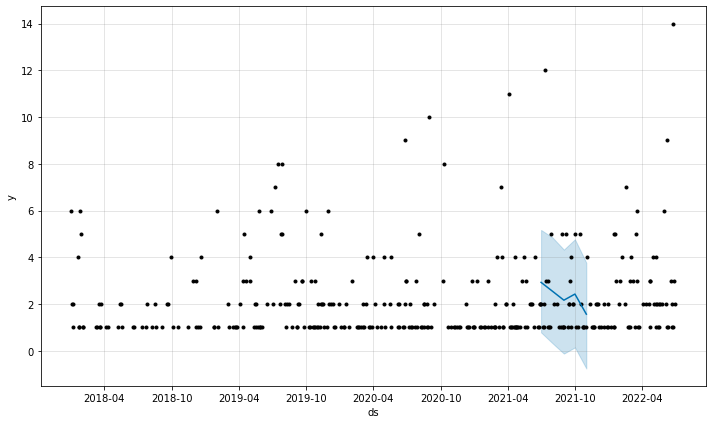

In [ ]:
import holidays
# define the model
model = Prophet(holidays = weekends)
model.add_country_holidays(country_name='US')
# fit the model
model.fit(df)
# define the period for which we want a prediction
future = list()
for i in range(7, 12):
	date = '2021-%02d' % i
	future.append([date])
future = DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])
# use the model to make a forecast
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
pyplot.show()

In [ ]:
from sklearn.metrics import mean_squared_error

testing = df[~(df['ds'] < '2021-07-01')]
testing = testing[~(testing['ds'] > '2021-12-01')]
# print(testing)
y_true = [1, 2, 1, 5, 4]
y_pred = forecast['yhat']
print(mean_squared_error(y_true, y_pred))
print(mean_squared_error(y_true, y_pred, squared=False))

SouthwestAirlineProphetMSE = mean_squared_error(y_true, y_pred)
SouthwestAirlineProphetRMSE = mean_squared_error(y_true, y_pred, squared=False)

#1, 2, 1, 5, 4

3.5844755176456693
1.8932711157268705


###Actual Forecast

In [ ]:
# make an out-of-sample forecast
from pandas import read_csv
from pandas import to_datetime
from pandas import DataFrame
from fbprophet import Prophet
from matplotlib import pyplot

In [ ]:
# load data
dfUnclean = SoutwestAirlineActualData.copy()
# prepare expected column names
df = pd.DataFrame(columns=['ds', 'y'])
df['ds'] = to_datetime(dfUnclean['Date'])
df['y'] = dfUnclean['Count']

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds      yhat  yhat_lower  yhat_upper
0 2022-07-01  2.581875    0.369632    4.864573
1 2022-08-01  2.729165    0.447139    4.932563
2 2022-09-01  2.056829   -0.184322    4.307862
3 2022-10-01  3.450680    1.186627    5.759175
4 2022-11-01  1.742438   -0.515883    3.929150


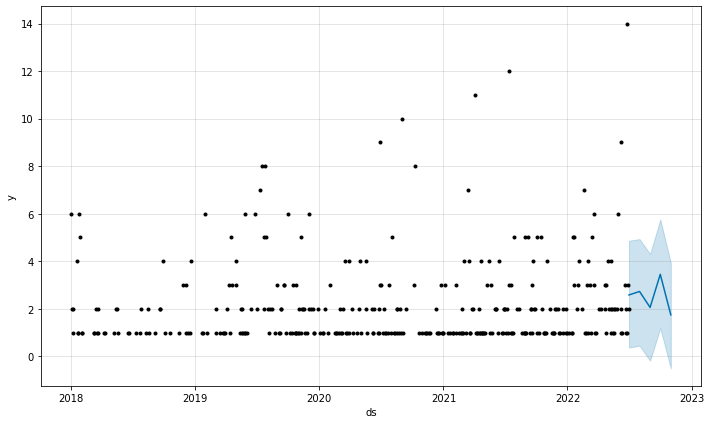

In [ ]:
# define the model
model = Prophet(holidays = weekends)
model.add_country_holidays(country_name='US')
# fit the model
model.fit(df)
# define the period for which we want a prediction
future = list()
for i in range(7, 12):
	date = '2022-%02d' % i
	future.append([date])
future = DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])
# use the model to make a forecast
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
pyplot.show()

In [ ]:
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon = '150 days')


df_p = performance_metrics(df_cv)
df_p

INFO:fbprophet:Making 5 forecasts with cutoffs between 2020-02-12 00:00:00 and 2022-02-01 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

,horizon,mse,rmse,mae,mape,mdape,coverage
0,18 days,2.941010,1.714937,1.048919,0.547972,0.493638,0.947368
1,19 days,2.934877,1.713148,1.047760,0.538878,0.493638,0.947368
2,20 days,2.614500,1.616942,0.898850,0.502980,0.410637,0.947368
3,21 days,6.481893,2.545956,1.282329,0.501087,0.493638,0.894737
4,22 days,6.499111,2.549335,1.296891,0.522911,0.493638,0.894737
...,...,...,...,...,...,...,...
97,146 days,8.622895,2.936477,1.656801,0.842207,0.512535,0.842105
98,147 days,9.489465,3.080498,1.822436,1.031710,0.711556,0.789474
99,148 days,9.420290,3.069249,1.772248,1.005389,0.512535,0.789474
100,149 days,10.271835,3.204970,1.993601,1.193811,0.752048,0.684211


In [ ]:
print(min(df_p['mse']))

1.2643714524029344


In [ ]:
SouthwestAirlineForecast = forecast.copy()
SouthwestAirlineProphetData = df.copy()

##Delta Airline

###Checking Accuracy

In [ ]:
# make an in-of-sample forecast
from pandas import read_csv
from pandas import to_datetime
from pandas import DataFrame
from fbprophet import Prophet
from matplotlib import pyplot

In [ ]:
# load data
dfUnclean = DeltaAirlineActualData.copy()
# prepare expected column names
df = pd.DataFrame(columns=['ds', 'y'])
df['ds'] = to_datetime(dfUnclean['Date'])
df['y'] = dfUnclean['Count']

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds      yhat  yhat_lower  yhat_upper
0 2021-07-01  5.474369    2.114792    8.963557
1 2021-08-01  1.849534   -1.754719    5.004436
2 2021-09-01  1.750751   -1.533946    5.026910
3 2021-10-01  1.556731   -1.824649    4.895016
4 2021-11-01  2.831774   -0.488413    6.049376


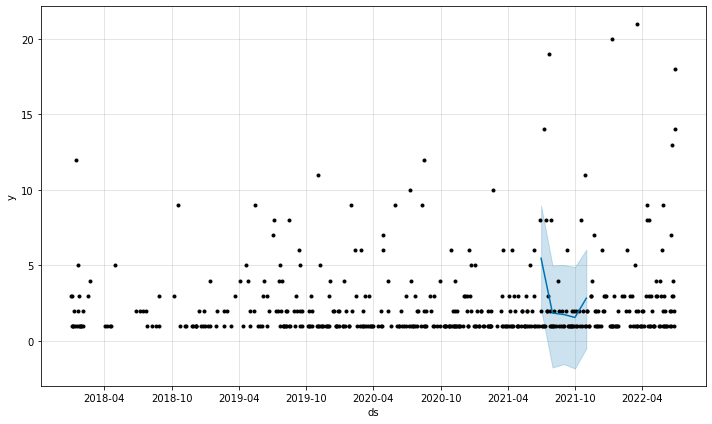

In [ ]:
import holidays
# define the model
model = Prophet(holidays = weekends)
model.add_country_holidays(country_name='US')
# fit the model
model.fit(df)
# define the period for which we want a prediction
future = list()
for i in range(7, 12):
	date = '2021-%02d' % i
	future.append([date])
future = DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])
# use the model to make a forecast
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
pyplot.show()

In [ ]:
from sklearn.metrics import mean_squared_error

testing = df[~(df['ds'] < '2021-07-01')]
testing = testing[~(testing['ds'] > '2021-12-01')]
# print(testing.head(30))
# print(testing.tail(30))
y_true = [2, 1, 2, 1, 1]
y_pred = forecast['yhat']
print(mean_squared_error(y_true, y_pred))
print(mean_squared_error(y_true, y_pred, squared=False))

DeltaAirlineProphetMSE = mean_squared_error(y_true, y_pred)
DeltaAirlineProphetRMSE = mean_squared_error(y_true, y_pred, squared=False)

#1, 2, 1, 5, 4

3.304083424928129
1.8177137907074725


###Actual Forecast

In [ ]:
# make an out-of-sample forecast
from pandas import read_csv
from pandas import to_datetime
from pandas import DataFrame
from fbprophet import Prophet
from matplotlib import pyplot

In [ ]:
# load data
dfUnclean = DeltaAirlineActualData.copy()
# prepare expected column names
df = pd.DataFrame(columns=['ds', 'y'])
df['ds'] = to_datetime(dfUnclean['Date'])
df['y'] = dfUnclean['Count']

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds      yhat  yhat_lower  yhat_upper
0 2022-07-01  5.141983    1.708339    8.351856
1 2022-08-01  2.447170   -0.774832    5.761710
2 2022-09-01  3.027495   -0.536834    6.373859
3 2022-10-01  2.334422   -1.173746    5.778075
4 2022-11-01  3.686737    0.620117    7.094072


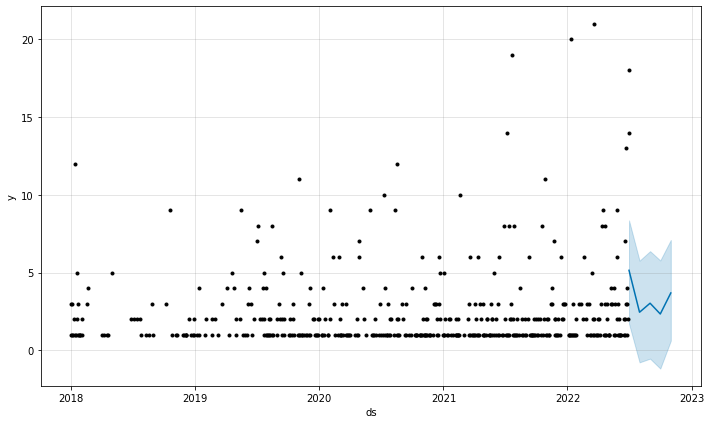

In [ ]:
# define the model
model = Prophet(holidays = weekends)
# fit the model
model.add_country_holidays(country_name='US')
model.fit(df)
# define the period for which we want a prediction
future = list()
for i in range(7, 12):
	date = '2022-%02d' % i
	future.append([date])
future = DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])
# use the model to make a forecast
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
pyplot.show()

In [ ]:
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon = '150 days')


df_p = performance_metrics(df_cv)
df_p

INFO:fbprophet:Making 5 forecasts with cutoffs between 2020-02-12 00:00:00 and 2022-02-01 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

,horizon,mse,rmse,mae,mape,mdape,coverage
0,15 days,9.397262,3.065495,2.006969,1.014827,0.908306,0.80
1,16 days,9.031590,3.005260,2.040145,1.024412,0.908306,0.78
2,18 days,8.459373,2.908500,2.054751,1.080662,0.908306,0.80
3,19 days,8.404345,2.899025,2.032582,1.058494,0.908306,0.80
4,20 days,8.394273,2.897287,2.021323,1.056784,0.908306,0.80
...,...,...,...,...,...,...,...
112,145 days,8.376942,2.894295,1.935992,0.854955,0.590623,0.80
113,146 days,8.467443,2.909887,1.961810,0.884377,0.590623,0.76
114,147 days,8.764410,2.960475,2.029520,0.969365,0.590623,0.72
115,149 days,12.978356,3.602548,2.414558,0.989249,0.633142,0.68


In [ ]:
print(min(df_p['mse']))

1.4286443627906975


In [ ]:
DeltaAirlineForecast = forecast.copy()
DeltaAirlineProphetData = df.copy()

##United Airline

###Checking Accuracy

In [ ]:
# make an in-of-sample forecast
from pandas import read_csv
from pandas import to_datetime
from pandas import DataFrame
from fbprophet import Prophet
from matplotlib import pyplot

In [ ]:
# load data
dfUnclean = UnitedAirlineActualData.copy()
# prepare expected column names
df = pd.DataFrame(columns=['ds', 'y'])
df['ds'] = to_datetime(dfUnclean['Date'])
df['y'] = dfUnclean['Count']

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds      yhat  yhat_lower  yhat_upper
0 2021-07-01  3.576368    0.605552    6.485915
1 2021-08-01  3.183926    0.154549    6.171873
2 2021-09-01  1.390068   -1.773440    4.263468
3 2021-10-01  4.122179    1.057630    6.989099
4 2021-11-01  1.975485   -1.157128    5.233441


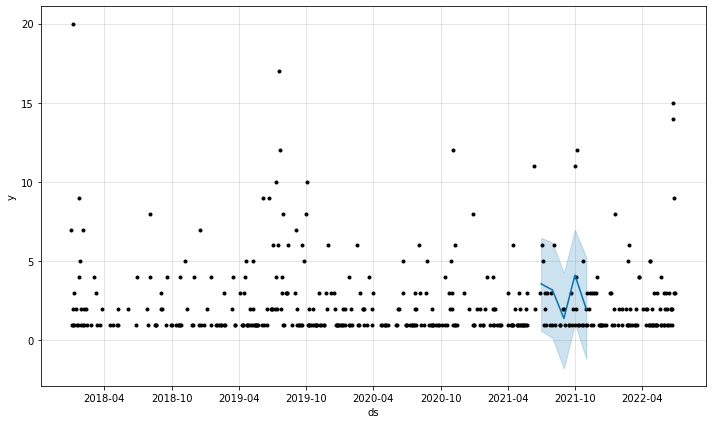

In [ ]:
import holidays
# define the model
model = Prophet(holidays = weekends)
model.add_country_holidays(country_name='US')
# fit the model
model.fit(df)
# define the period for which we want a prediction
future = list()
for i in range(7, 12):
	date = '2021-%02d' % i
	future.append([date])
future = DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])
# use the model to make a forecast
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
pyplot.show()

In [ ]:
from sklearn.metrics import mean_squared_error

testing = df[~(df['ds'] < '2021-07-01')]
testing = testing[~(testing['ds'] > '2021-12-01')]
# print(testing.head(30))
# print(testing.tail(30))
y_true = [6, 1, 2, 11, 2]
y_pred = forecast['yhat']
print(mean_squared_error(y_true, y_pred))
print(mean_squared_error(y_true, y_pred, squared=False))

UnitedAirlineProphetMSE = mean_squared_error(y_true, y_pred)
UnitedAirlineProphetRMSE = mean_squared_error(y_true, y_pred, squared=False)

#1, 2, 1, 5, 4

11.664113316979563
3.415276462744936


###Actual Forecast

In [ ]:
# make an out-of-sample forecast
from pandas import read_csv
from pandas import to_datetime
from pandas import DataFrame
from fbprophet import Prophet
from matplotlib import pyplot

In [ ]:
# load data
dfUnclean = UnitedAirlineActualData.copy()
# prepare expected column names
df = pd.DataFrame(columns=['ds', 'y'])
df['ds'] = to_datetime(dfUnclean['Date'])
df['y'] = dfUnclean['Count']

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds      yhat  yhat_lower  yhat_upper
0 2022-07-01  4.602207    1.781412    7.722696
1 2022-08-01  2.944938   -0.057804    5.906915
2 2022-09-01  1.412420   -1.758783    4.655909
3 2022-10-01  3.469305    0.710002    6.605380
4 2022-11-01  2.131557   -0.970006    5.243903


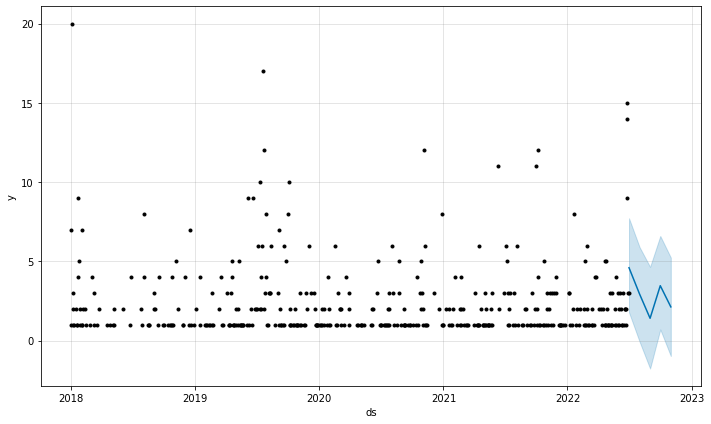

In [ ]:
# define the model
model = Prophet(holidays = weekends)
# fit the model
model.add_country_holidays(country_name='US')
model.fit(df)
# define the period for which we want a prediction
future = list()
for i in range(7, 12):
	date = '2022-%02d' % i
	future.append([date])
future = DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])
# use the model to make a forecast
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
pyplot.show()

In [ ]:
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon = '150 days')


df_p = performance_metrics(df_cv)
df_p

INFO:fbprophet:Making 5 forecasts with cutoffs between 2020-02-12 00:00:00 and 2022-02-01 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

,horizon,mse,rmse,mae,mape,mdape,coverage
0,17 days,2.892439,1.700717,1.198159,0.599809,0.525529,0.894737
1,18 days,2.789892,1.670297,1.151876,0.553527,0.525529,0.894737
2,20 days,1.496226,1.223203,0.904224,0.521727,0.471419,0.947368
3,21 days,2.130786,1.459721,1.079523,0.529289,0.525529,0.894737
4,22 days,2.126538,1.458265,1.076516,0.526282,0.525529,0.894737
...,...,...,...,...,...,...,...
103,145 days,19.708795,4.439459,2.795917,0.937389,0.708214,0.736842
104,146 days,19.728731,4.441704,2.824191,0.946814,0.708214,0.736842
105,147 days,20.091598,4.482365,2.895419,0.865024,0.680031,0.710526
106,148 days,20.545752,4.532742,2.979295,0.948899,0.680031,0.684211


In [ ]:
print(min(df_p['mse']))

0.7364186735377038


In [ ]:
UnitedAirlineForecast = forecast.copy()
UnitedAirlineProphetData = df.copy()

##DATA

In [ ]:
print(AmericanAirlineForecast)
print(SouthwestAirlineForecast)
print(DeltaAirlineForecast)
print(UnitedAirlineForecast)

          ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2022-07-01  3.433754   -1.757935    6.150743     3.433754     3.433754   
1 2022-08-01  3.439468   -0.929125    6.697261     3.439322     3.439587   
2 2022-09-01  3.445181   -0.790659    6.867190     3.444326     3.446016   
3 2022-10-01  3.450710    0.044039    7.373235     3.448698     3.452373   
4 2022-11-01  3.456424   -2.043582    5.891483     3.452970     3.459415   

   Christmas Day  Christmas Day_lower  Christmas Day_upper  \
0            0.0                  0.0                  0.0   
1            0.0                  0.0                  0.0   
2            0.0                  0.0                  0.0   
3            0.0                  0.0                  0.0   
4            0.0                  0.0                  0.0   

   Christmas Day (Observed)  ...    weekly  weekly_lower  weekly_upper  \
0                       0.0  ... -0.294705     -0.294705     -0.294705   
1                     

In [ ]:
AmericanAirlineForecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'Christmas Day', 'Christmas Day_lower', 'Christmas Day_upper',
       'Christmas Day (Observed)', 'Christmas Day (Observed)_lower',
       'Christmas Day (Observed)_upper', 'Columbus Day', 'Columbus Day_lower',
       'Columbus Day_upper', 'Independence Day', 'Independence Day_lower',
       'Independence Day_upper', 'Independence Day (Observed)',
       'Independence Day (Observed)_lower',
       'Independence Day (Observed)_upper', 'Labor Day', 'Labor Day_lower',
       'Labor Day_upper', 'Martin Luther King Jr. Day',
       'Martin Luther King Jr. Day_lower', 'Martin Luther King Jr. Day_upper',
       'Memorial Day', 'Memorial Day_lower', 'Memorial Day_upper',
       'New Year's Day', 'New Year's Day_lower', 'New Year's Day_upper',
       'New Year's Day (Observed)', 'New Year's Day (Observed)_lower',
       'New Year's Day (Observed)_upper', 'Thanksgiving', 'Thanksgiving_lower',
       'Thanksgiv

In [ ]:
print(AmericanAirlineForecast['ds'],AmericanAirlineForecast['yhat'])

0   2022-07-01
1   2022-08-01
2   2022-09-01
3   2022-10-01
4   2022-11-01
Name: ds, dtype: datetime64[ns] 0    2.269811
1    3.039603
2    3.162406
3    3.517173
4    1.839747
Name: yhat, dtype: float64


#Data Untuk CSV

In [ ]:
#American Airlines
AmericanAirlineProphetDataToCSV = pd.DataFrame(columns=['Date', 'facebook prophet', 'airlines'])
AmericanAirlineProphetDataToCSV['Date'] = AmericanAirlineForecast['ds']
AmericanAirlineProphetDataToCSV['facebook prophet'] = AmericanAirlineForecast['yhat']
AmericanAirlineProphetDataToCSV['airlines'] = "American Airlines"
#Southwest Airlines
SouthwestAirlineProphetDataToCSV = pd.DataFrame(columns=['Date', 'facebook prophet', 'airlines'])
SouthwestAirlineProphetDataToCSV['Date'] = SouthwestAirlineForecast['ds']
SouthwestAirlineProphetDataToCSV['facebook prophet'] = SouthwestAirlineForecast['yhat']
SouthwestAirlineProphetDataToCSV['airlines'] = "Southwest Airlines"
#Delta Airlines
DeltaAirlineProphetDataToCSV = pd.DataFrame(columns=['Date', 'facebook prophet', 'airlines'])
DeltaAirlineProphetDataToCSV['Date'] = DeltaAirlineForecast['ds']
DeltaAirlineProphetDataToCSV['facebook prophet'] = DeltaAirlineForecast['yhat']
DeltaAirlineProphetDataToCSV['airlines'] = "Delta Airlines"
#United Airlines
UnitedAirlineProphetDataToCSV = pd.DataFrame(columns=['Date', 'facebook prophet', 'airlines'])
UnitedAirlineProphetDataToCSV['Date'] = UnitedAirlineForecast['ds']
UnitedAirlineProphetDataToCSV['facebook prophet'] = UnitedAirlineForecast['yhat']
UnitedAirlineProphetDataToCSV['airlines'] = "United Airlines"

In [ ]:
fullDataProphetToCSV = pd.concat((AmericanAirlineProphetDataToCSV, SouthwestAirlineProphetDataToCSV, DeltaAirlineProphetDataToCSV, UnitedAirlineProphetDataToCSV))

In [ ]:
fullDataProphetToCSV

In [ ]:
AmericanAirlineSARIMADataToCSV = pd.DataFrame({'Date':AmericanAirlinesSARIMAForecast.index, 'SARIMA':AmericanAirlinesSARIMAForecast.values})
SouthwestAirlineSARIMADataToCSV = pd.DataFrame({'Date':SoutwestAirlinesSARIMAForecast.index, 'SARIMA':SoutwestAirlinesSARIMAForecast.values})
DeltaAirlineSARIMADataToCSV = pd.DataFrame({'Date':DeltaAirlinesSARIMAForecast.index, 'SARIMA':DeltaAirlinesSARIMAForecast.values})
UnitedAirlineSARIMADataToCSV = pd.DataFrame({'Date':UnitedAirlinesSARIMAForecast.index, 'SARIMA':UnitedAirlinesSARIMAForecast.values})

fullDataSARIMAToCSV = pd.concat((AmericanAirlineSARIMADataToCSV, SouthwestAirlineSARIMADataToCSV, DeltaAirlineSARIMADataToCSV, UnitedAirlineSARIMADataToCSV))

In [ ]:
fullDataSARIMAToCSV

In [ ]:
fullDataToCSV = fullDataProphetToCSV.copy()
fullDataToCSV['SARIMA'] = fullDataSARIMAToCSV['SARIMA']

In [ ]:
fullDataToCSV

In [ ]:
from google.colab import files

fullDataToCSV.to_csv('output.csv', encoding = 'utf-8-sig') 
files.download('output.csv')

#EVALUATION

##SARIMA

In [ ]:
print("American Airline MSE (SARIMA) : " , AmericanAirlineSARIMAMSE)
print("American Airline RMSE (SARIMA) : " , AmericanAirlineSARIMARMSE)
print("Southwest Airline MSE (SARIMA) : " , SouthwestAirlineSARIMAMSE)
print("Southwest Airline RMSE (SARIMA) : " , SouthwestAirlineSARIMARMSE)
print("Delta Airline MSE (SARIMA) : " , DeltaAirlineSARIMAMSE)
print("Delta Airline RMSE (SARIMA) : " , DeltaAirlineSARIMARMSE)
print("United Airline MSE (SARIMA) : " , UnitedAirlineSARIMAMSE)
print("United Airline RMSE (SARIMA) : " , UnitedAirlineSARIMARMSE)

American Airline MSE (SARIMA) :  2.933531325596629
American Airline RMSE (SARIMA) :  1.7127554774679978
Southwest Airline MSE (SARIMA) :  0.5993407978243029
Southwest Airline RMSE (SARIMA) :  0.7741710391278551
Delta Airline MSE (SARIMA) :  24.8
Delta Airline RMSE (SARIMA) :  4.979959839195493
United Airline MSE (SARIMA) :  2.5612260671042746
United Airline RMSE (SARIMA) :  1.6003831001058073


## Facebook Prophet

In [ ]:
print("American Airline MSE (Facebook Prophet) : " , AmericanAirlineProphetMSE)
print("American Airline RMSE (Facebook Prophet) : " , AmericanAirlineProphetRMSE)
print("Southwest Airline MSE (Facebook Prophet) : " , SouthwestAirlineProphetMSE)
print("Southwest Airline RMSE (Facebook Prophet) : " , SouthwestAirlineProphetRMSE)
print("Delta Airline MSE (Facebook Prophet) : " , DeltaAirlineProphetMSE)
print("Delta Airline RMSE (Facebook Prophet) : " , DeltaAirlineProphetRMSE)
print("United Airline MSE (Facebook Prophet) : " , UnitedAirlineProphetMSE)
print("United Airline RMSE (Facebook Prophet) : " , UnitedAirlineProphetRMSE)

American Airline MSE (Facebook Prophet) :  1.180792801496637
American Airline RMSE (Facebook Prophet) :  1.086642904314309
Southwest Airline MSE (Facebook Prophet) :  3.5844755176456693
Southwest Airline RMSE (Facebook Prophet) :  1.8932711157268705
Delta Airline MSE (Facebook Prophet) :  3.304083424928129
Delta Airline RMSE (Facebook Prophet) :  1.8177137907074725
United Airline MSE (Facebook Prophet) :  11.664113316979563
United Airline RMSE (Facebook Prophet) :  3.415276462744936
